In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# Check important features using PCA
from sklearn.decomposition import PCA
from operator import itemgetter

In [2]:
FILE = '../data/globalterrorismdb.csv'
raw_df = pd.read_csv(FILE, index_col='eventid', encoding='ISO-8859-1')

/Users/ninz/.local/share/virtualenvs/cs297-fZk1rqQo/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd.set_option('display.max_columns', None)
raw_df.head(5)

iyear  imonth  iday approxdate  extended resolution  country  \
eventid                                                                      
197000000001   1970       7     2        NaN         0        NaN       58   
197000000002   1970       0     0        NaN         0        NaN      130   
197001000001   1970       1     0        NaN         0        NaN      160   
197001000002   1970       1     0        NaN         0        NaN       78   
197001000003   1970       1     0        NaN         0        NaN      101   

                     country_txt  region                   region_txt  \
eventid                                                                 
197000000001  Dominican Republic       2  Central America & Caribbean   
197000000002              Mexico       1                North America   
197001000001         Philippines       5               Southeast Asia   
197001000002              Greece       8               Western Europe   
197001000003               Japan       4                    East Asia   

             provstate           city   latitude   longitude  specificity  \
eventid                                                                     
197000000001       NaN  Santo Domingo  18.456792  -69.951164          1.0   
197000000002       NaN    Mexico city  19.432608  -99.133207          1.0   
197001000001    Tarlac        Unknown  15.478598  120.599741          4.0   
197001000002    Attica         Athens  37.983773   23.728157          1.0   
197001000003       NaN        Fukouka  33.580412  130.396361          1.0   

              vicinity location summary  crit1  crit2  crit3  doubtterr  \
eventid                                                                   
197000000001         0      NaN     NaN      1      1      1          0   
197000000002         0      NaN     NaN      1      1      1          0   
197001000001         0      NaN     NaN      1      1      1          0   
197001000002         0      NaN     NaN      1      1      1          0   
197001000003         0      NaN     NaN      1      1      1         -9   

              alternative alternative_txt  multiple  success  suicide  \
eventid                                                                 
197000000001          NaN             NaN         0        1        0   
197000000002          NaN             NaN         0        1        0   
197001000001          NaN             NaN         0        1        0   
197001000002          NaN             NaN         0        1        0   
197001000003          NaN             NaN         0        1        0   

              attacktype1                 attacktype1_txt  attacktype2  \
eventid                                                                  
197000000001            1                   Assassination          NaN   
197000000002            6     Hostage Taking (Kidnapping)          NaN   
197001000001            1                   Assassination          NaN   
197001000002            3               Bombing/Explosion          NaN   
197001000003            7  Facility/Infrastructure Attack          NaN   

             attacktype2_txt  attacktype3 attacktype3_txt  targtype1  \
eventid                                                                
197000000001             NaN          NaN             NaN         14   
197000000002             NaN          NaN             NaN          7   
197001000001             NaN          NaN             NaN         10   
197001000002             NaN          NaN             NaN          7   
197001000003             NaN          NaN             NaN          7   

                            targtype1_txt  targsubtype1  \
eventid                                                   
197000000001  Private Citizens & Property          68.0   
197000000002      Government (Diplomatic)          45.0   
197001000001          Journalists & Media          54.0   
197001000002      Government (Diplomatic)          46.0   

#### Examine the data

Eyeballing the data, here are some of the less obvious but useful columns

- success
- attacktypes
- targettypes
- targetsubtypes
- nationality of target ?
- weapontypes
- related?


**NOTE**
Mention in the report that data such as kills are removed since the objective is to just relate terrorist attacks to several factors. Some terrorist attacks that target individuals only exist but it might be too little to consider.

In [4]:
# Get mappings for numeric columns with text equivalent
def extract_mapping(df, numeric, text):
    _tmp = raw_df[[numeric, text]]
    _tmp = _tmp.drop_duplicates()
    return {r[numeric]: r[text] for i, r in _tmp.iterrows()}

country_mappings = extract_mapping(raw_df, 'country', 'country_txt')
region_mappings = extract_mapping(raw_df, 'region', 'region_txt')
attack_type_mappings = extract_mapping(raw_df, 'attacktype1', 'attacktype1_txt')
target_type_mappings = extract_mapping(raw_df, 'targtype1', 'targtype1_txt')
target_sub_type_mappings = extract_mapping(raw_df, 'targsubtype1', 'targsubtype1_txt')
nationality_target_mappings = extract_mapping(raw_df, 'natlty1', 'natlty1_txt')
weapon_type_mappings = extract_mapping(raw_df, 'weaptype1', 'weaptype1_txt')

In [5]:
minified_cols = ['iyear', 'imonth', 'iday', 'extended', 'resolution', 
                'country', 'region', 'success', 'attacktype1', 'targtype1',
               'natlty1', 'weaptype1']
minified_df = raw_df[minified_cols]

minified_df.head(2)

iyear  imonth  iday  extended resolution  country  region  \
eventid                                                                   
197000000001   1970       7     2         0        NaN       58       2   
197000000002   1970       0     0         0        NaN      130       1   

              success  attacktype1  targtype1  natlty1  weaptype1  
eventid                                                            
197000000001        1            1         14     58.0         13  
197000000002        1            6          7     21.0         13

In [6]:
country_mappings

{58: 'Dominican Republic',
 130: 'Mexico',
 160: 'Philippines',
 78: 'Greece',
 101: 'Japan',
 217: 'United States',
 218: 'Uruguay',
 98: 'Italy',
 499: 'East Germany (GDR)',
 65: 'Ethiopia',
 83: 'Guatemala',
 222: 'Venezuela',
 362: 'West Germany (FRG)',
 199: 'Switzerland',
 102: 'Jordan',
 185: 'Spain',
 30: 'Brazil',
 60: 'Egypt',
 11: 'Argentina',
 110: 'Lebanon',
 96: 'Ireland',
 209: 'Turkey',
 158: 'Paraguay',
 94: 'Iran',
 603: 'United Kingdom',
 45: 'Colombia',
 26: 'Bolivia',
 145: 'Nicaragua',
 142: 'Netherlands',
 21: 'Belgium',
 97: 'Israel',
 38: 'Canada',
 14: 'Australia',
 153: 'Pakistan',
 230: 'Zambia',
 198: 'Sweden',
 49: 'Costa Rica',
 406: 'South Yemen',
 36: 'Cambodia',
 201: 'Taiwan',
 156: 'Panama',
 106: 'Kuwait',
 155: 'West Bank and Gaza Strip',
 15: 'Austria',
 236: 'Czechoslovakia',
 92: 'India',
 69: 'France',
 428: 'South Vietnam',
 6: 'Algeria',
 61: 'El Salvador',
 205: 'Thailand',
 87: 'Haiti',
 195: 'Sudan',
 136: 'Morocco',
 53: 'Cyprus',
 138: '

In [7]:
grouped_by_year_region = minified_df.groupby(['iyear', 'region']).size().to_frame('number_of_attacks').reset_index()
grouped_by_year = minified_df.groupby(['iyear', 'country']).size().to_frame('number_of_attacks').reset_index()
grouped_by_month = minified_df.groupby(['iyear', 'imonth', 'country']).size().to_frame('number_of_attacks').reset_index()

In [146]:
# mean number of attack is 46
def label_attack(r):
    if r['number_of_attacks'] < 20:
        return 'few'
    elif r['number_of_attacks'] < 40:
        return 'minimal'
    elif r['number_of_attacks'] < 60:
        return 'average'
    else:
        return 'many'

# mean for per region is 330.135659
def label_attack_region(r):
    if r['number_of_attacks'] < 110:
        return 'very_few'
    elif r['number_of_attacks'] < 220:
        return 'few'
    elif r['number_of_attacks'] < 330:
        return 'average'
    elif r['number_of_attacks'] < 440:
        return 'above_average'
    else:
        return 'many'

grouped_by_month['attack_category'] = grouped_by_month.apply (label_attack, axis=1)
grouped_by_year['attack_category'] = grouped_by_year.apply (label_attack, axis=1)

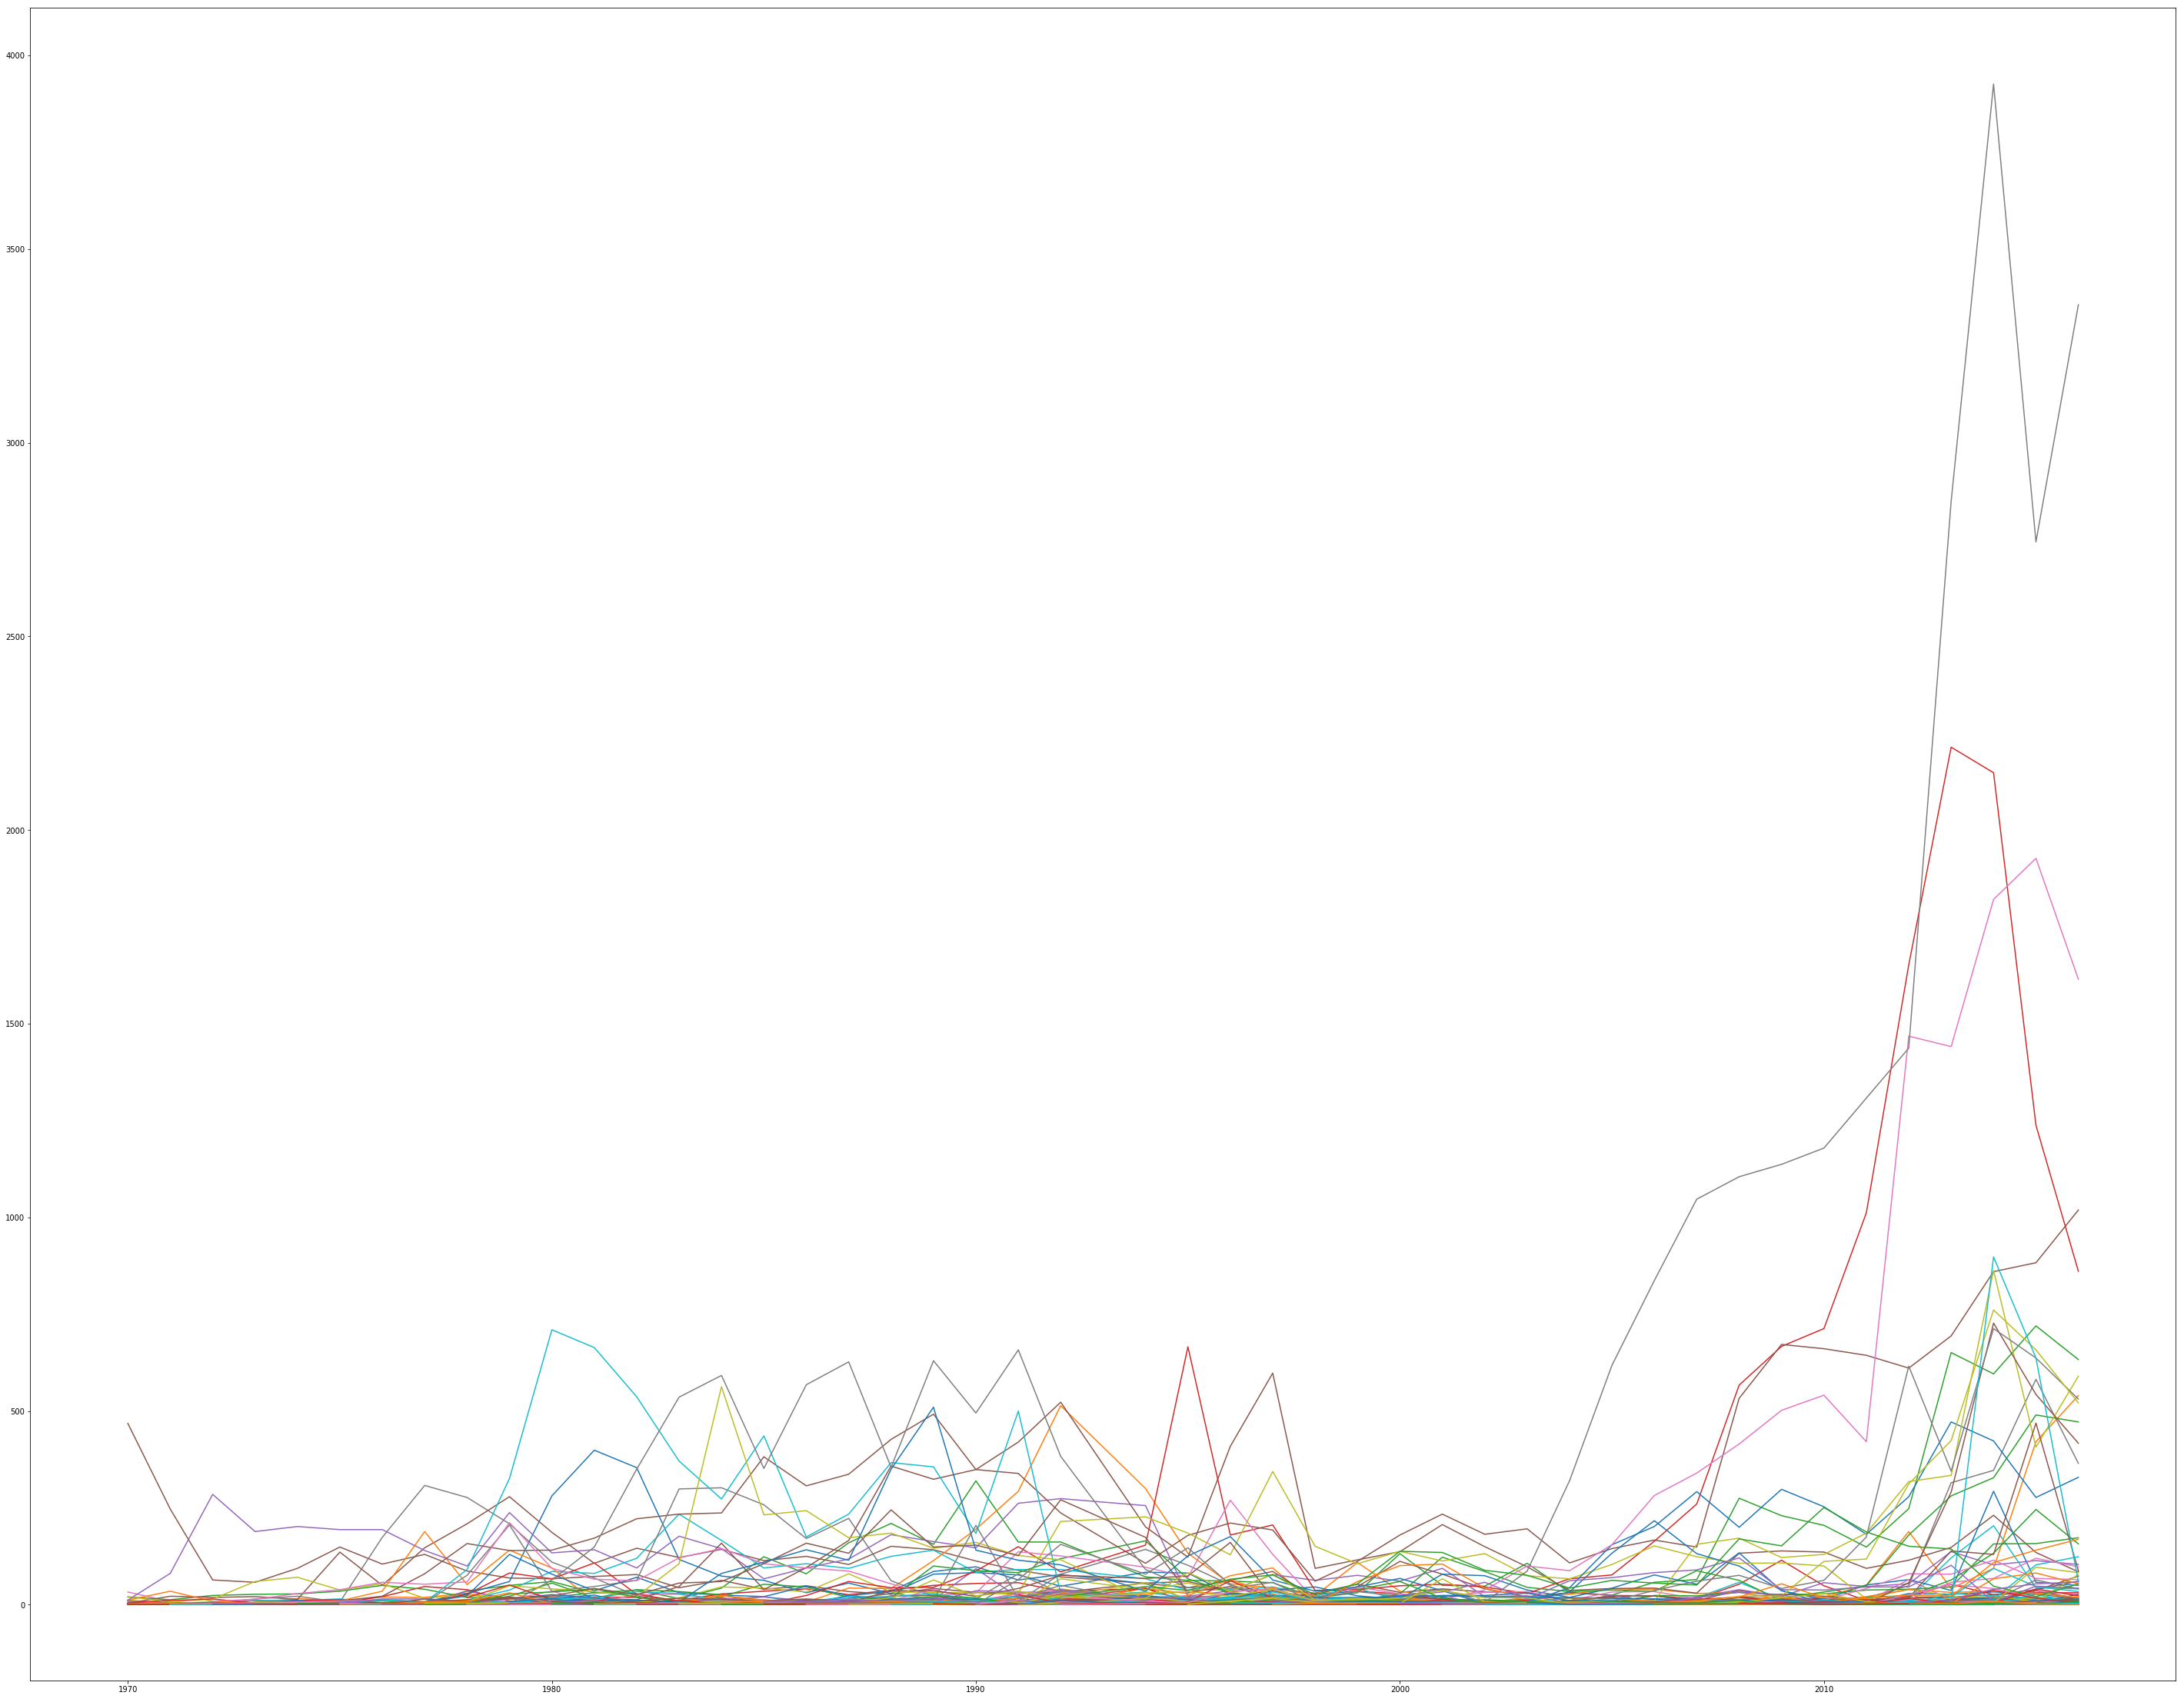

In [147]:
plt.figure(figsize=(50,40))
for _c in country_mappings:
    x = grouped_by_year[grouped_by_year.country == _c].iyear
    y = grouped_by_year[grouped_by_year.country == _c].number_of_attacks
    plt.plot(x,y)
#     print(grouped_by_year[grouped_by_year.country == _c].iyear)

plt.show()

In [148]:
# grouped_by_year_region.groupby(['iyear'])['number_of_attacks'].agg(
#     {'number_of_attack': 'mean'}).reset_index()

grouped_by_year_region.head(2)

iyear  region  number_of_attacks
0   1970       1                472
1   1970       2                  7

In [149]:
# Econ data merged
FILE = '../data/economic-terrorism-data.csv'
eco_df = pd.read_csv(FILE)

In [150]:
minified_eco_cols = ['iyear', 'imonth', 'iday', 'extended', 'country', 'region', 'success', 
                     'attacktype1', 'targtype1', 'natlty1', 'weaptype1', 'gdp', 'inf', 'pop']
eco_df = eco_df[minified_eco_cols]

In [151]:
eco_df.head()

iyear  imonth  iday  extended  country  region  success  attacktype1  \
0   1970       7     2         0       58       2        1            1   
1   1970       0     0         0      130       1        1            6   
2   1970       1     0         0      160       5        1            1   
3   1970       1     0         0       78       8        1            3   
4   1970       1     0         0      101       4        1            7   

   targtype1  natlty1  weaptype1           gdp        inf          pop  
0         14     58.0         13  1.485400e+09   2.104839    4503114.0  
1          7     21.0         13  3.554171e+10   2.632475   52029861.0  
2         10    217.0         13  6.687205e+09  15.155504   35804729.0  
3          7    217.0          6  1.313986e+10   7.990874    8792806.0  
4          7    217.0          8  2.115142e+11  24.093187  104345000.0

In [152]:

eco_year_region = eco_df.groupby(['iyear', 'region'])['gdp', 'inf', 'pop'].agg(
    {'gdp': 'mean', 'inf': 'mean', 'pop': 'mean'}).reset_index()


eco_year = eco_df.groupby(['iyear', 'country'])['gdp', 'inf', 'pop'].agg(
    {'gdp': 'mean', 'inf': 'mean', 'pop': 'mean'}).reset_index()



In [153]:
eco_year_region['number_of_attacks'] = grouped_by_year_region['number_of_attacks']
eco_year['number_of_attacks'] = grouped_by_year['number_of_attacks']

In [154]:
eco_year_region.head(10)

iyear  region           gdp        inf           pop  number_of_attacks
0   1970       1  1.067289e+12   2.229519  2.036251e+08              472.0
1   1970       2  1.512400e+09   3.807591  4.841642e+06                7.0
2   1970       3  1.533112e+10   6.089432  1.841784e+07               65.0
3   1970       4  2.115142e+11  24.093187  1.043450e+08                2.0
4   1970       5  6.687205e+09  15.155504  3.580473e+07               10.0
5   1970       6  1.002709e+10   4.306905  5.809076e+07                1.0
6   1970       8  1.310959e+11   4.863308  5.249436e+07               49.0
7   1970       9  2.150218e+11   0.000000  7.816929e+07               12.0
8   1970      10  7.528566e+09   3.704788  1.558153e+07               29.0
9   1970      11  0.000000e+00   0.000000  2.841508e+07                3.0

In [156]:
eco_year_region['attack_category'] = eco_year_region.apply (label_attack_region, axis=1)
eco_year['attack_category'] = eco_year.apply (label_attack, axis=1)

In [157]:
eco_year_region.head(5)

iyear  region           gdp        inf           pop  number_of_attacks  \
0   1970       1  1.067289e+12   2.229519  2.036251e+08              472.0   
1   1970       2  1.512400e+09   3.807591  4.841642e+06                7.0   
2   1970       3  1.533112e+10   6.089432  1.841784e+07               65.0   
3   1970       4  2.115142e+11  24.093187  1.043450e+08                2.0   
4   1970       5  6.687205e+09  15.155504  3.580473e+07               10.0   

  attack_category  
0            many  
1        very_few  
2        very_few  
3        very_few  
4        very_few

In [158]:
def perform_classifier_with_PCA(X, y, n_comp, n_estimators):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

    clf = RandomForestClassifier(random_state=0, n_estimators=n_estimators).fit(X_train, y_train)
    
    pca = PCA(n_components=n_comp).fit(X)
    loadings = pca.components_
    var = pca.explained_variance_ratio_
    headers = X.columns
    
    
    fig, axes = plt.subplots(figsize=(15, 15))

    for i, ax in enumerate(var):
        plt.subplot(3, 2, i+1)
        plt.title('PCA{} Factor Loading ({})'.format(i+1, round(var[i], 2)))
        data = zip(headers, loadings[i], abs(loadings[i]))
        headers_s, loadings_actual, loadings_abs = zip(*sorted(data, reverse=True, key=itemgetter(2)))
        plt.bar(range(len(headers)), loadings_actual)
        plt.xticks(range(len(headers)), headers_s, rotation=45)

    plt.show()
    
    score = clf.score(X_test, y_test)
    print('Score on the test dataset', score)
    
def get_region_gdp(_df, comparison):
    for i, r in region_mappings.items():
        fig, ax = plt.subplots(figsize=(5, 5))
        plt.title('{}'.format(r))

        _ax = ax.twinx()

        x = _df[_df.region == i].iyear
        y = _df[_df.region == i].number_of_attacks
        ax.plot(x,y, 'g-')

        x = _df[_df.region == i].iyear
        y = _df[_df.region == i][comparison]
        _ax.plot(x,y, 'b-')

        ax.set_xlabel('Year data')
        ax.set_ylabel('Number of attacks', color='g')
        _ax.set_ylabel(comparison, color='b')

    plt.show()
    
def get_per_country_gov(_df, country, comparison):
    
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title('{}'.format(country_mappings[country]))

    _ax = ax.twinx()

    x = _df[_df.country == country].iyear
    y = _df[_df.country == country].number_of_attacks
    ax.plot(x,y, 'g-')

    x = _df[_df.country == country].iyear
    y = _df[_df.country == country][comparison]
    _ax.plot(x,y, 'b-')

    ax.set_xlabel('Year data')
    ax.set_ylabel('Number of attacks', color='g')
    _ax.set_ylabel(comparison, color='b')

    plt.show()

# Economic Data

## Per region dataset

- Get X features and y target
- Split the dataset for verification
- Apply some classifiers -- RandomForestClassifier (tried other classifier before, this one has the highest)
- Measure score on test set

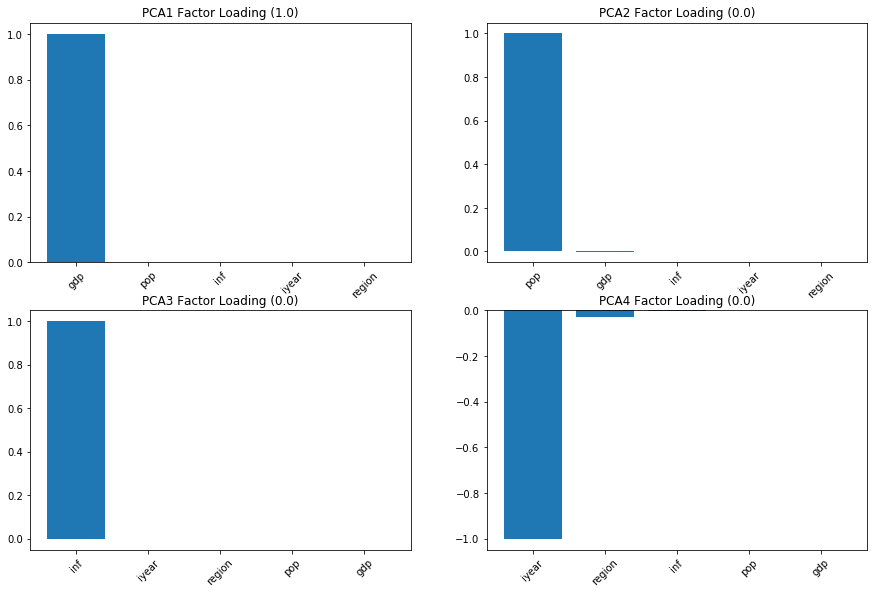

Score on the test dataset 0.7044025157232704


In [164]:
X = eco_year_region[['iyear', 'region', 'gdp', 'inf', 'pop']]
y = eco_year_region['attack_category']

# Using all feature from economic data
perform_classifier_with_PCA(X, y, 4, 45)

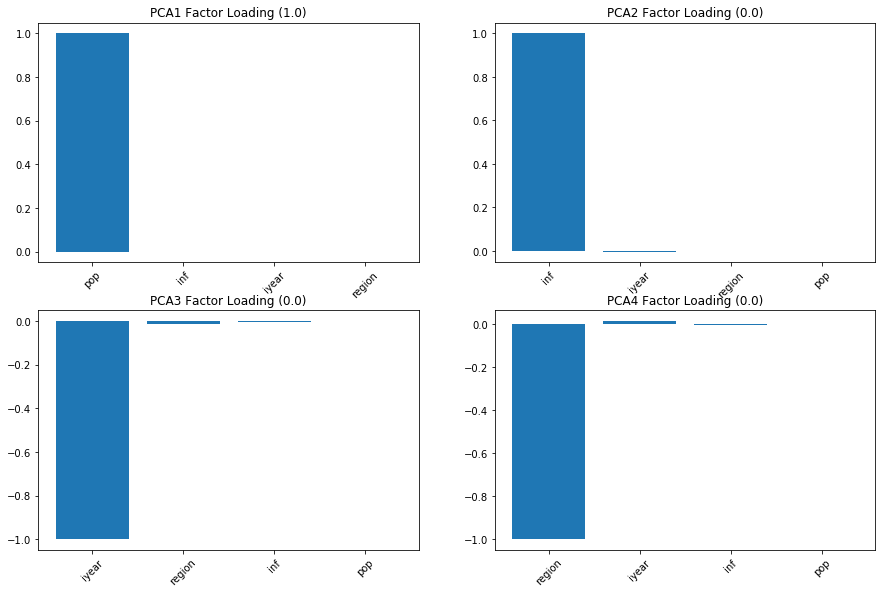

Score on the test dataset 0.710691823899371


In [171]:
X = eco_year_region[['iyear', 'region', 'inf', 'pop']]
y = eco_year_region['attack_category']

# Removing the gdp feature
# n_estimator @ 30 gives the highest prediction result
perform_classifier_with_PCA(X, y, 4, 30)

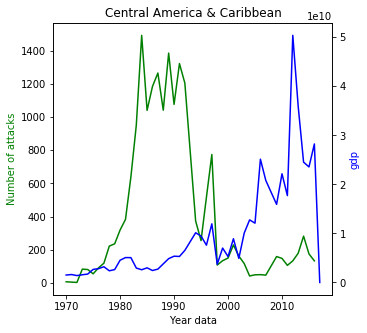

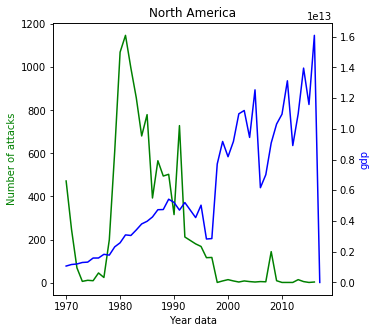

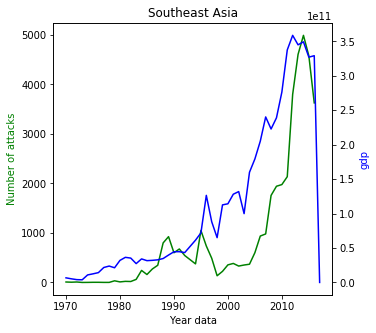

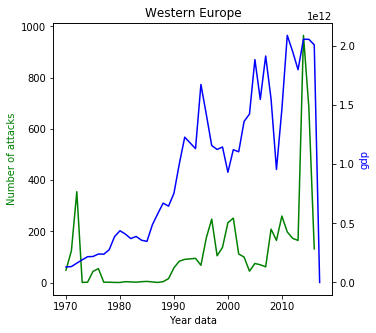

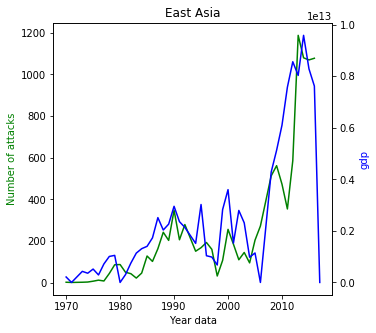

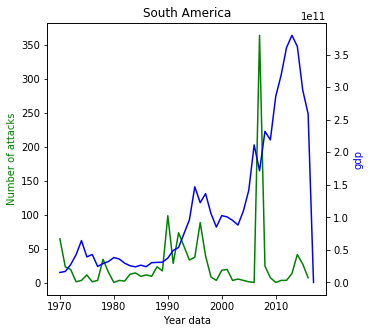

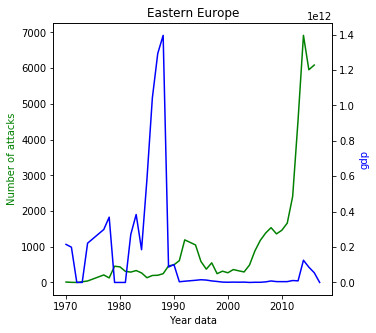

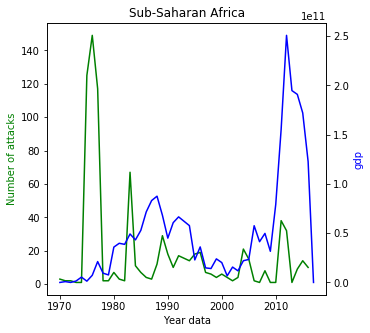

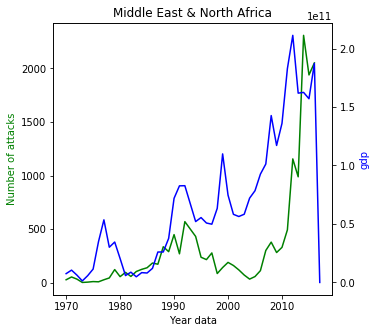

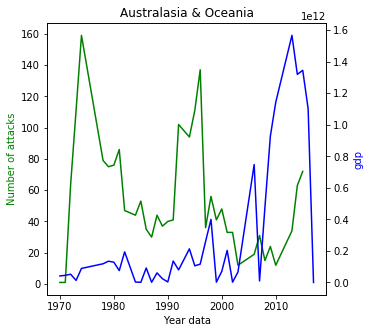

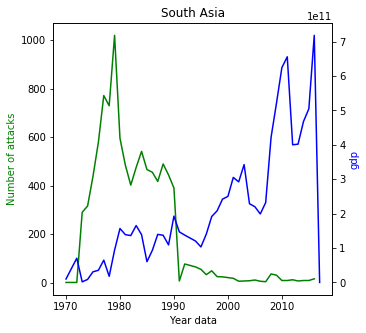

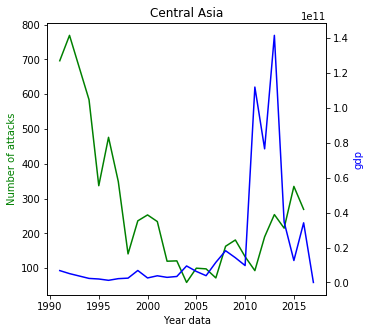

In [172]:
get_region_gdp(eco_year_region, 'gdp')

Proportional GDP vs Terrorism trends

- Southeast Asia
- East Asia
- South America
- Middle East and North Africa
- Western Eu?

Most of these regions are 3rd world countries.


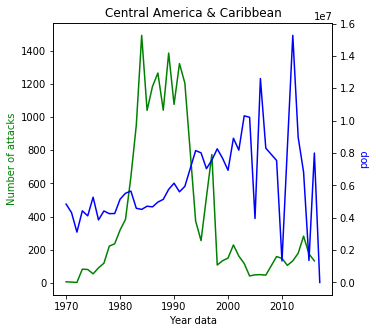

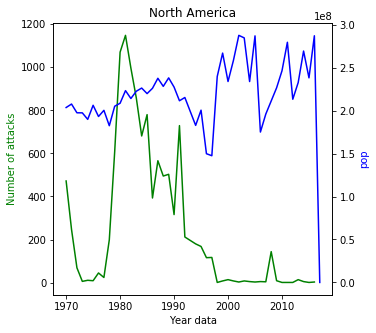

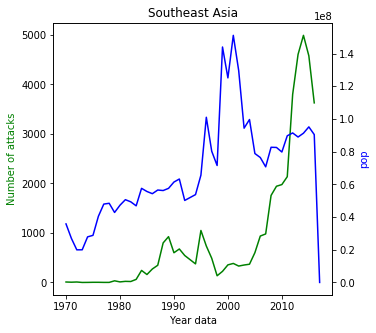

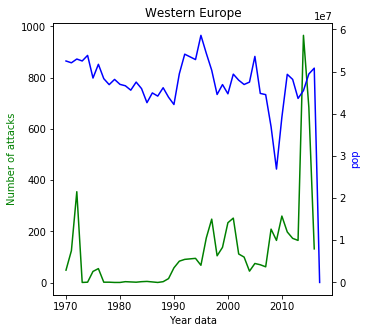

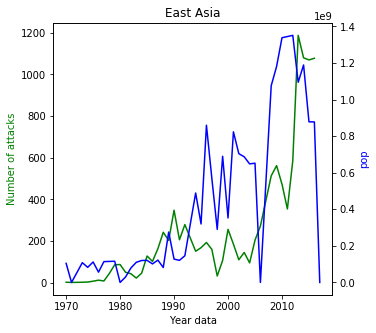

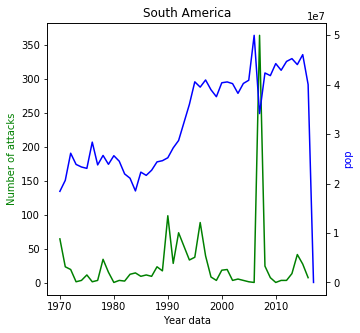

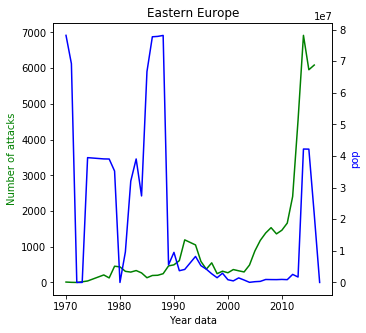

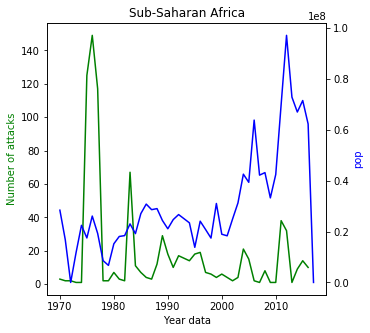

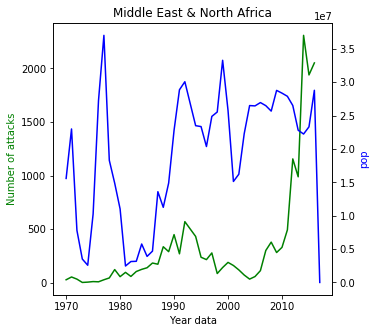

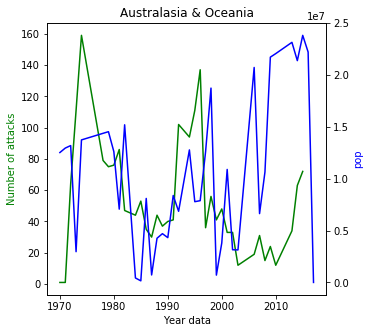

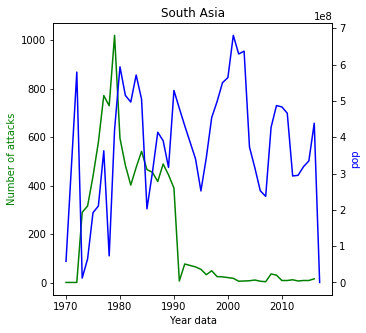

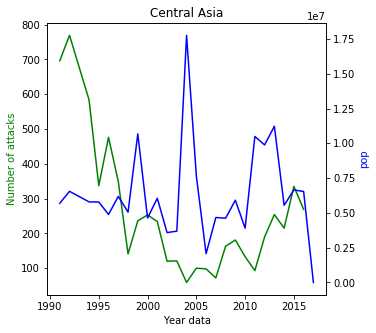

In [74]:
get_region_gdp(eco_year_region, 'pop')

#### Population as the main driver in the per region basis

`GDP` score `0.7044025157232704`
`population` score `0.710691823899371`

Population yeilds the best score with relation to terrorism.

## Per country dataset

- Get X features and y target
- Split the dataset for verification
- Apply some classifiers -- RandomForestClassifier (tried other classifier before, this one has the highest)
- Measure score on test set

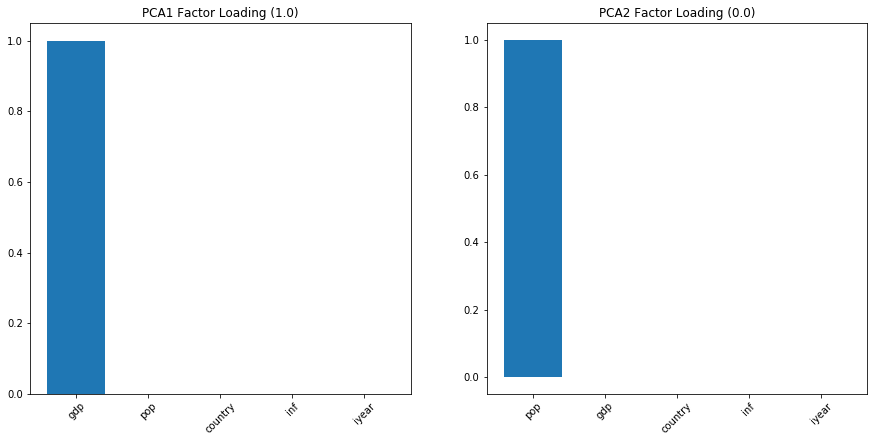

Score on the test dataset 0.6908768821966342


In [75]:
X = eco_year[['iyear', 'country', 'gdp', 'inf', 'pop']]
y = eco_year['attack_category']

# Removing the gdp feature
# n_estimator @ 30 gives the highest prediction result
perform_classifier_with_PCA(X, y, 2, 30)

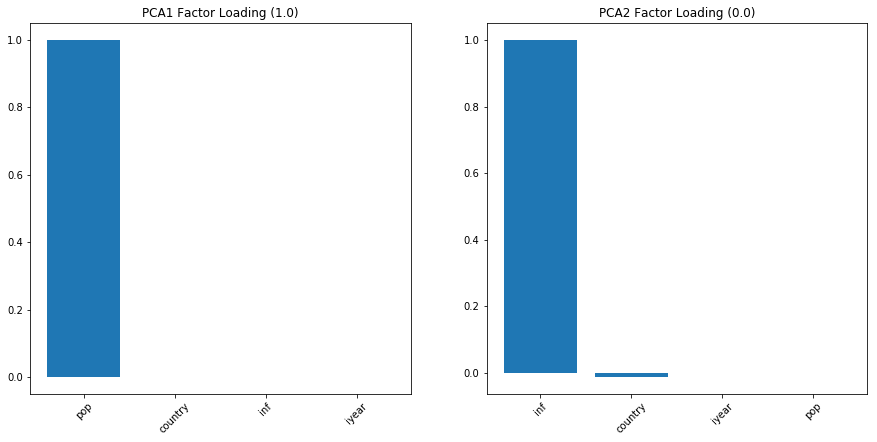

Score on the test dataset 0.6891054030115146


In [76]:
X = eco_year[['iyear', 'country', 'inf', 'pop']]
y = eco_year['attack_category']

# Removing the gdp feature
# n_estimator @ 30 gives the highest prediction result
perform_classifier_with_PCA(X, y, 2, 30)

#### GDP as the main driver in the per country basis

The prediction score of `0.6908768821966342` is better than `0.6891054030115146`

In the per region and per country data, it can be seen that BOTH GDP and Population has the same relation score in terms of terrorism.

In [77]:
# Get the top 5 countries in terms of GDP
s = eco_year.groupby(['country'])['gdp', 'inf', 'pop', 'number_of_attacks'].agg(
    {'gdp': 'mean', 'inf': 'mean', 'pop': 'mean', 'number_of_attacks': 'sum'}).reset_index()
s.sort_values(by=['gdp'], ascending=False, inplace=True)
top5_gdp = s.country[0: 5]
s.sort_values(by=['number_of_attacks'], ascending=False, inplace=True)
top5_terrorism = s.country[0: 10]

--Top GDP--


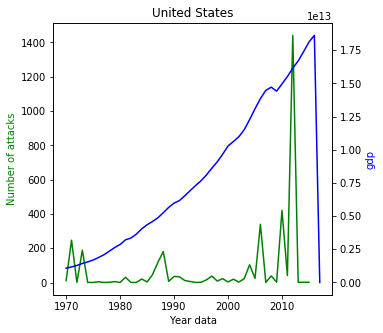

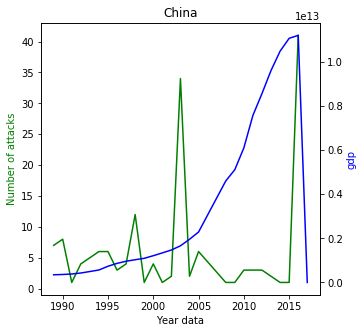

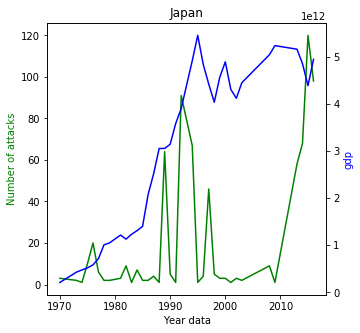

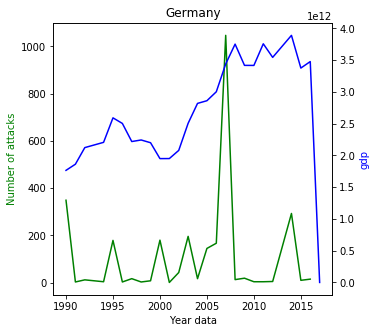

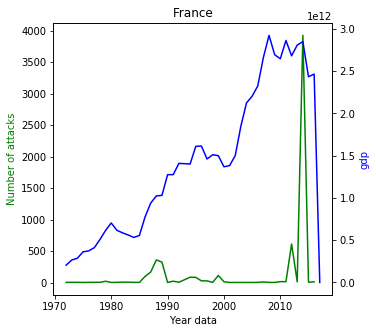

--Top Terrorism--


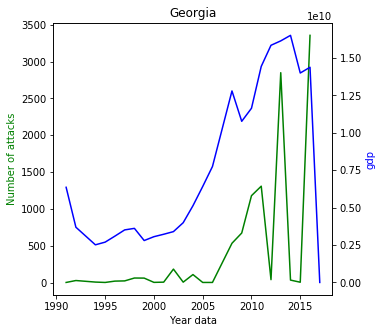

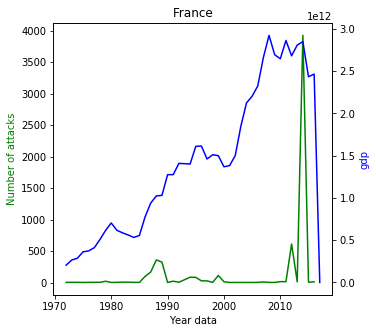

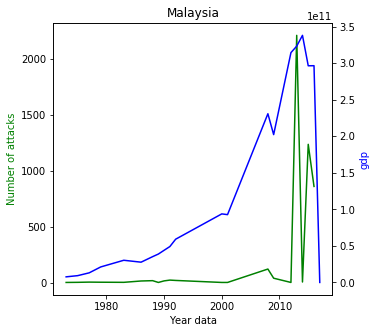

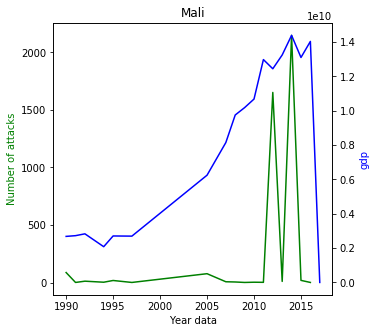

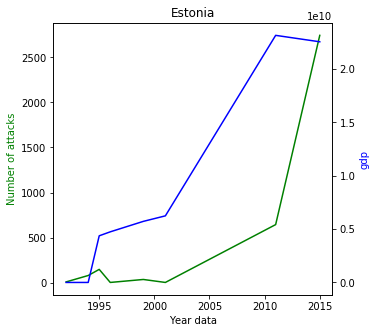

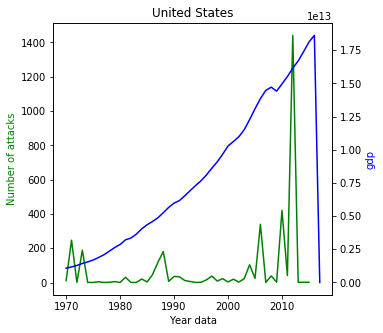

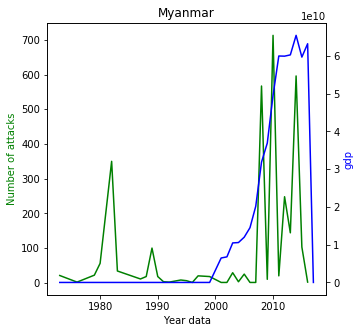

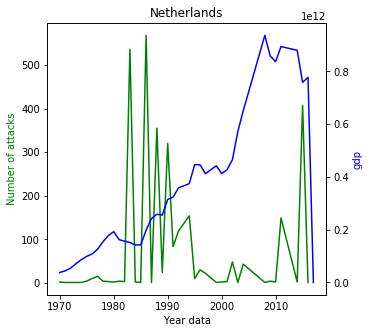

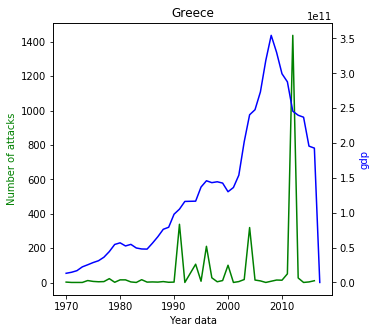

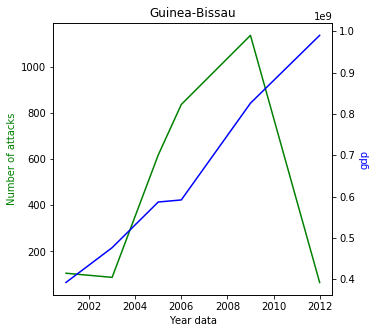

In [78]:
print('--Top GDP--')
for t in top5_gdp:
    get_per_country_gov(eco_year, t, 'gdp')
    
print('--Top Terrorism--')
for t in top5_terrorism:
    get_per_country_gov(eco_year, t, 'gdp')
    

Looking at terrorism data per region in the context of GDP might be a better option. Looking on a per country level might produce skewed data since countries like the USA, even though encounter a lot of terrorism attack, still has high GDP

# Govt data

In [79]:
FILE = '../data/cleaned_gov2.csv'
gov_df = pd.read_csv(FILE, index_col='idx')

In [80]:
gov_df.head(2)

countryname  ifs  year        system  finittrm  military execme execrlc  \
idx                                                                            
0    South Sudan  NaN  2011  Presidential       NaN       1.0   SPLM       0   
1    South Sudan  NaN  2012  Presidential       NaN       1.0   SPLM       0   

     numgov  numopp  legelec  exelec  execme_num  is_presidential  \
idx                                                                 
0         0       0      0.0     0.0           0              1.0   
1       332       0      0.0     0.0           0              1.0   

     is_parliamentary  is_essembly_elected  is_left_oriented  \
idx                                                            
0                 0.0                  0.0               0.0   
1                 0.0                  0.0               0.0   

     is_right_oriented  is_center_oriented  numadmin  country_code  \
idx                                                                  
0                  0.0                 0.0         0        1004.0   
1                  0.0                 0.0       332        1004.0   

     change_ruling_party  
idx                       
0                    0.0  
1                    0.0

In [81]:
FILE = '../data/cleaned_gov3.csv'
gov2_df = pd.read_csv(FILE, index_col='idx')

In [82]:
gov2_df.head()

iyear  country  number_of_attacks attack_category  idx2  countryname  \
idx                                                                         
191   1975       11                 38         minimal   192    Argentina   
192   1975       15                  2             few   306      Austria   
193   1975       45                 10             few  1332     Colombia   
194   1975       53                  2             few  1538       Cyprus   
195   1975       61                  3             few  5419  El Salvador   

     ifs  year         system  finittrm  military       execme execrlc  \
idx                                                                      
191  ARG  1975   Presidential       0.0       0.0     Peronist    Left   
192  AUT  1975  Parliamentary       1.0       0.0          SPO    Left   
193  COL  1975   Presidential       1.0       0.0           PL  Center   
194  CYP  1975   Presidential    -999.0       0.0  independent       0   
195  SLV  1975   Presidential       1.0       1.0          PCN   Right   

     numgov  numopp  legelec  exelec  execme_num  is_presidential  \
idx                                                                 
191       0       0      0.0     0.0          13              1.0   
192       0       0      1.0     0.0          22              0.0   
193     113      83      0.0     0.0          82              1.0   
194       0       0      0.0     0.0           1              1.0   
195      52       0      0.0     0.0         351              1.0   

     is_parliamentary  is_essembly_elected  is_left_oriented  \
idx                                                            
191               0.0                  0.0               1.0   
192               1.0                  0.0               1.0   
193               0.0                  0.0               0.0   
194               0.0                  0.0               0.0   
195               0.0                  0.0               0.0   

     is_right_oriented  is_center_oriented  numadmin  country_code  \
idx                                                                  
191                0.0                 0.0         0            11   
192                0.0                 0.0         0            15   
193                0.0                 1.0        30            45   
194                0.0                 0.0         0            53   
195                1.0                 0.0        52            61   

     change_ruling_party  
idx                       
191                  0.0  
192                  0.0  
193                  0.0  
194                  0.0  
195                  0.0

In [215]:
cols = [
    'iyear', 'country', 'number_of_attacks', 'attack_category', 'military', 'numopp', 'numadmin',
    'legelec', 'exelec', 'numgov', 'is_presidential', 'is_parliamentary', 'is_essembly_elected', 
    'is_left_oriented', 'is_right_oriented', 'is_center_oriented', 'change_ruling_party'
]

gov_terror = gov2_df[cols]

In [216]:
gov_terror.groupby('is_parliamentary').size()
# Just convert it to 0 since its just 48

is_parliamentary
0.0    1988
1.0     903
dtype: int64

In [217]:
gov_terror.loc[gov_terror.military == -999.0, 'military'] = 0.0
gov_terror.loc[gov_terror.legelec == -999.0, 'legelec'] = 0.0
gov_terror.loc[gov_terror.exelec == -999.0, 'exelec'] = 0.0

/Users/ninz/.local/share/virtualenvs/cs297-fZk1rqQo/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [220]:
gov_terror = gov_terror.fillna(gov_terror.mean())

## Per country dataset

- Get X features and y target
- Split the dataset for verification
- Apply some classifiers -- RandomForestClassifier (tried other classifier before, this one has the highest)
- Measure score on test set

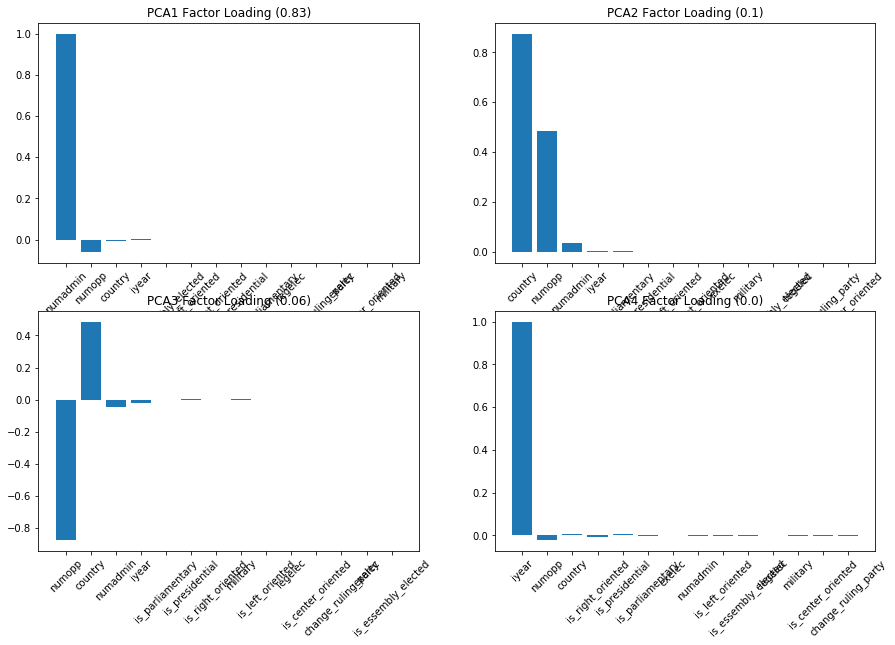

Score on the test dataset 0.8145161290322581


In [221]:
X = gov_terror[['iyear', 'country', 'military', 'numopp', 'numadmin', 'legelec', 'exelec', 'is_presidential', 'is_parliamentary', 'is_essembly_elected', 
    'is_left_oriented', 'is_right_oriented', 'is_center_oriented', 'change_ruling_party']]
y = gov_terror['attack_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
perform_classifier_with_PCA(X, y, 4, 30)


The number of seats present seems to be a big factor. The data is the total number of available HIGHER level positions.

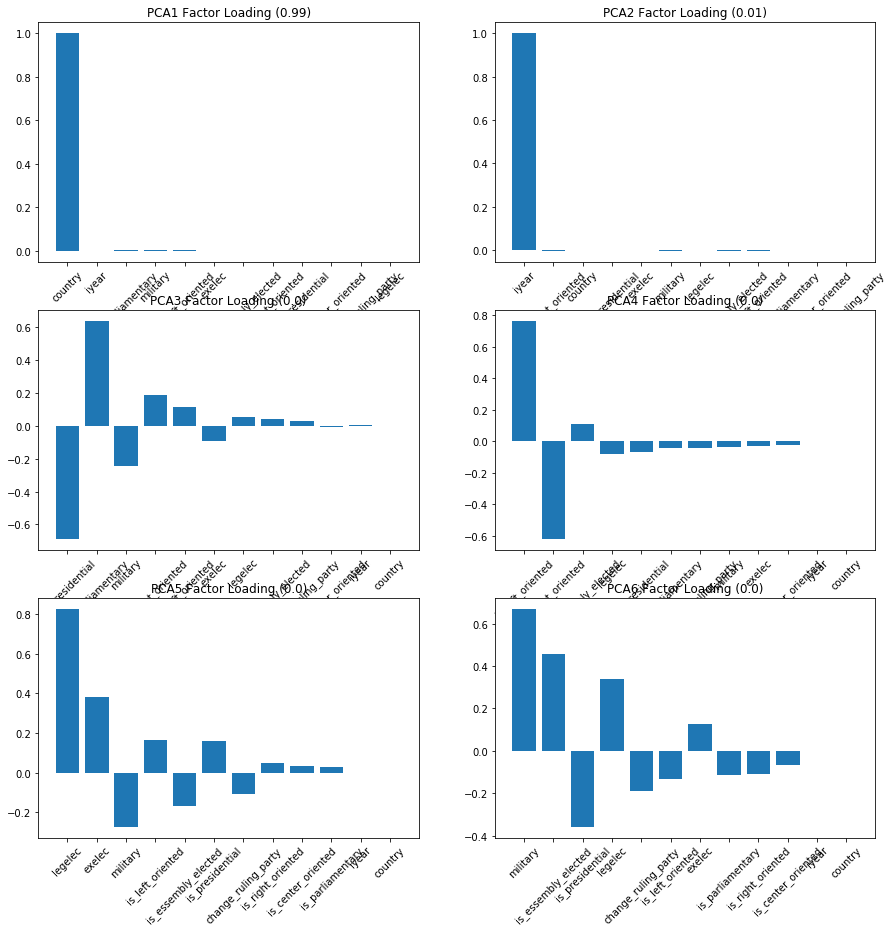

Score on the test dataset 0.7684331797235023


In [115]:
X = gov_terror[['iyear', 'country', 'military','legelec', 'exelec', 'is_presidential', 'is_parliamentary', 'is_essembly_elected', 
    'is_left_oriented', 'is_right_oriented', 'is_center_oriented', 'change_ruling_party']]
y = gov_terror['attack_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
perform_classifier_with_PCA(X, y, 6, 30)


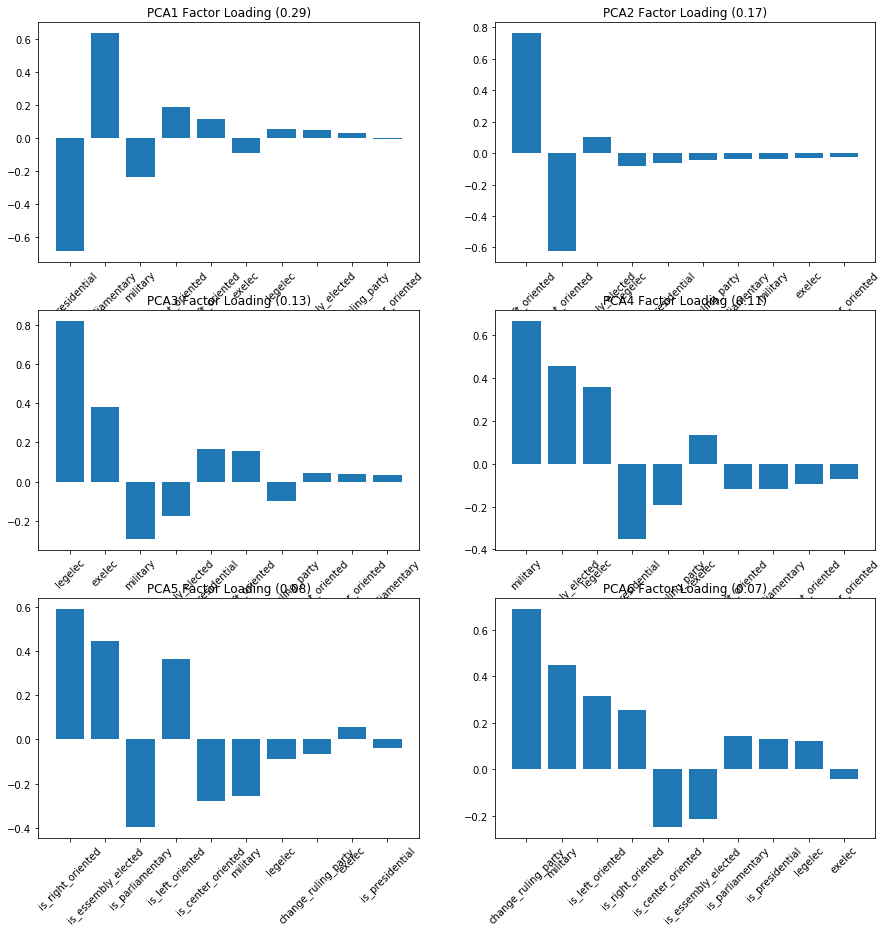

Score on the test dataset 0.7338709677419355


In [222]:
X = gov_terror[['military','legelec', 'exelec', 'is_presidential', 'is_parliamentary', 'is_essembly_elected', 
    'is_left_oriented', 'is_right_oriented', 'is_center_oriented', 'change_ruling_party']]
y = gov_terror['attack_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
perform_classifier_with_PCA(X, y, 6, 30)


#### Comparison of features

- `Number of govt position` - 0.8145161290322581
- `Year and Country` - 0.7684331797235023
- `mixed features (govt type)` - 0.7338709677419355

Number of govt position seems to be the biggest factor that contribute to terrorism for each country.
However it is also worth noting that the combination of several features such as `Government type` can also be used as a good metric to measure terrorism activity per country

## Per Region dataset

- Get X features and y target
- Split the dataset for verification
- Apply some classifiers -- RandomForestClassifier (tried other classifier before, this one has the highest)
- Measure score on test set

In [229]:
# create_mapping
country_region_map = {}
c_reg_map = minified_df.groupby(['country', 'region']).size().reset_index()
for v in c_reg_map.values:
    country_region_map[v[0]] = v[1]
    
gov_terror.head()

iyear  country  number_of_attacks attack_category  military  numopp  \
idx                                                                        
191   1975       11                 38         minimal       0.0       0   
192   1975       15                  2             few       0.0       0   
193   1975       45                 10             few       0.0      83   
194   1975       53                  2             few       0.0       0   
195   1975       61                  3             few       1.0       0   

     numadmin  legelec  exelec  numgov  is_presidential  is_parliamentary  \
idx                                                                         
191         0      0.0     0.0       0              1.0               0.0   
192         0      1.0     0.0       0              0.0               1.0   
193        30      0.0     0.0     113              1.0               0.0   
194         0      0.0     0.0       0              1.0               0.0   
195        52      0.0     0.0      52              1.0               0.0   

     is_essembly_elected  is_left_oriented  is_right_oriented  \
idx                                                             
191                  0.0               1.0                0.0   
192                  0.0               1.0                0.0   
193                  0.0               0.0                0.0   
194                  0.0               0.0                0.0   
195                  0.0               0.0                1.0   

     is_center_oriented  change_ruling_party  region  
idx                                                   
191                 0.0                  0.0       3  
192                 0.0                  0.0       8  
193                 1.0                  0.0       3  
194                 0.0                  0.0       8  
195                 0.0                  0.0       2

In [232]:
gov_terror['region'] = gov_terror.country.apply(lambda x: country_region_map[x])
gov_terror.head(2)

iyear  country  number_of_attacks attack_category  military  numopp  \
idx                                                                        
191   1975       11                 38         minimal       0.0       0   
192   1975       15                  2             few       0.0       0   

     numadmin  legelec  exelec  numgov  is_presidential  is_parliamentary  \
idx                                                                         
191         0      0.0     0.0       0              1.0               0.0   
192         0      1.0     0.0       0              0.0               1.0   

     is_essembly_elected  is_left_oriented  is_right_oriented  \
idx                                                             
191                  0.0               1.0                0.0   
192                  0.0               1.0                0.0   

     is_center_oriented  change_ruling_party  region  
idx                                                   
191                 0.0                  0.0       3  
192                 0.0                  0.0       8

In [234]:
gov_terror_region = gov_terror.groupby(['iyear', 'region'])[
    'military', 'numopp', 'numadmin', 'legelec', 'exelec',
    'is_presidential', 'is_parliamentary', 'is_essembly_elected', 
    'is_left_oriented', 'is_right_oriented', 'is_center_oriented', 'change_ruling_party'
    ].agg({
        'military': 'sum', 
        'numopp': 'mean', 
        'numadmin': 'mean',
        'legelec': 'sum',
        'exelec': 'sum',
        'is_presidential': 'sum',
        'is_parliamentary': 'sum',
        'is_essembly_elected': 'sum',
        'is_left_oriented': 'sum',
        'is_right_oriented': 'sum',
        'is_center_oriented': 'sum',
        'change_ruling_party': 'sum',
        'number_of_attacks': 'sum'
    }).reset_index()


/Users/ninz/.local/share/virtualenvs/cs297-fZk1rqQo/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [246]:
gov_terror_region['attack_category'] = gov_terror_region.apply (label_attack_region, axis=1)
gov_terror_region.head(2)

iyear  region  military  numopp   numadmin  legelec  exelec  \
0   1975       1       0.0     0.0   0.000000      0.0     0.0   
1   1975       2       3.0    10.0  17.666667      0.0     0.0   

   is_presidential  is_parliamentary  is_essembly_elected  is_left_oriented  \
0              2.0               0.0                  0.0               1.0   
1              3.0               0.0                  0.0               0.0   

   is_right_oriented  is_center_oriented  change_ruling_party  \
0                1.0                 0.0                  0.0   
1                2.0                 0.0                  0.0   

   number_of_attacks attack_category  
0                159             few  
1                  9        very_few

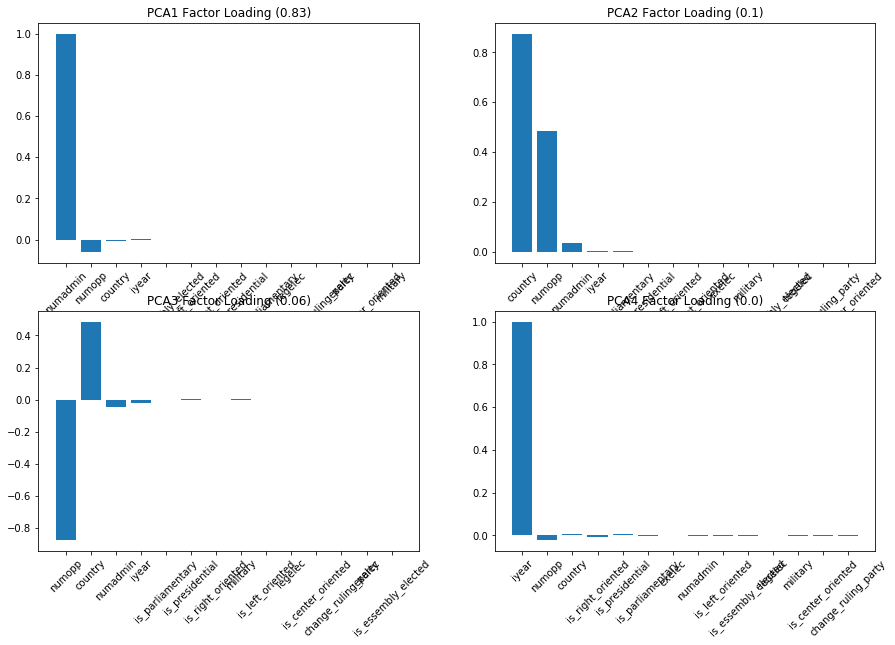

Score on the test dataset 0.8145161290322581


In [236]:
X = gov_terror[['iyear', 'country', 'military', 'numopp', 'numadmin', 'legelec', 'exelec', 'is_presidential', 'is_parliamentary', 'is_essembly_elected', 
    'is_left_oriented', 'is_right_oriented', 'is_center_oriented', 'change_ruling_party']]
y = gov_terror['attack_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
perform_classifier_with_PCA(X, y, 4, 30)


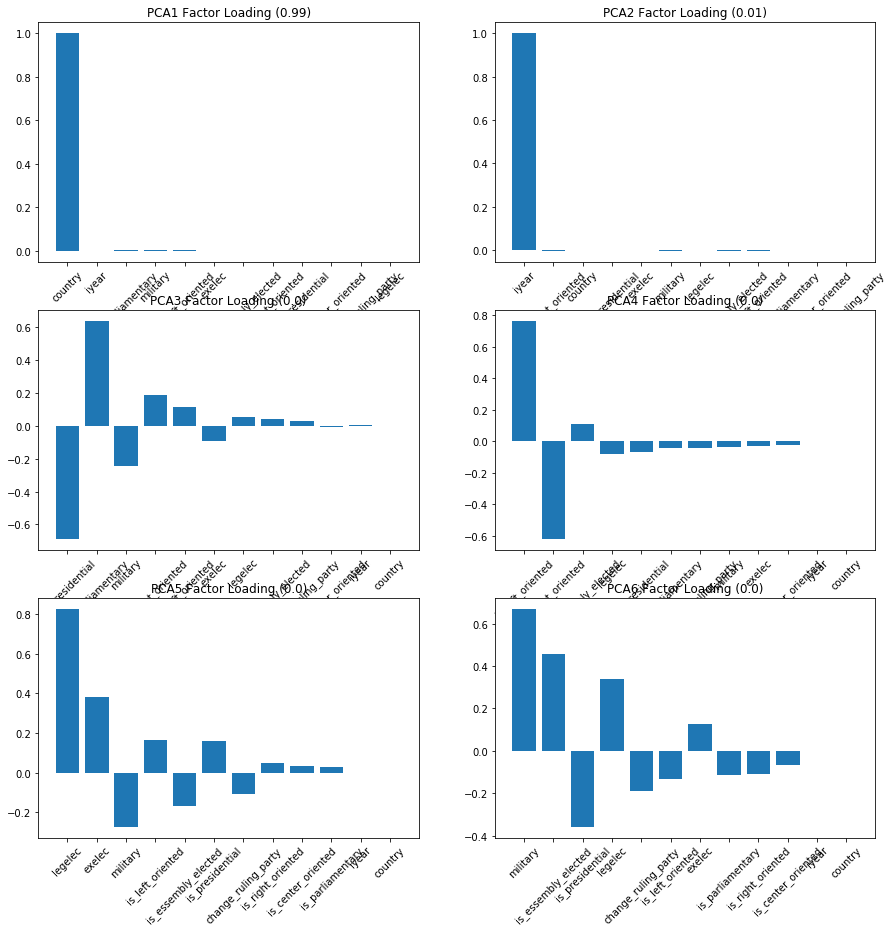

Score on the test dataset 0.7684331797235023


In [237]:
X = gov_terror[['iyear', 'country', 'military', 'legelec', 'exelec', 'is_presidential', 'is_parliamentary', 'is_essembly_elected', 
    'is_left_oriented', 'is_right_oriented', 'is_center_oriented', 'change_ruling_party']]
y = gov_terror['attack_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
perform_classifier_with_PCA(X, y, 6, 30)


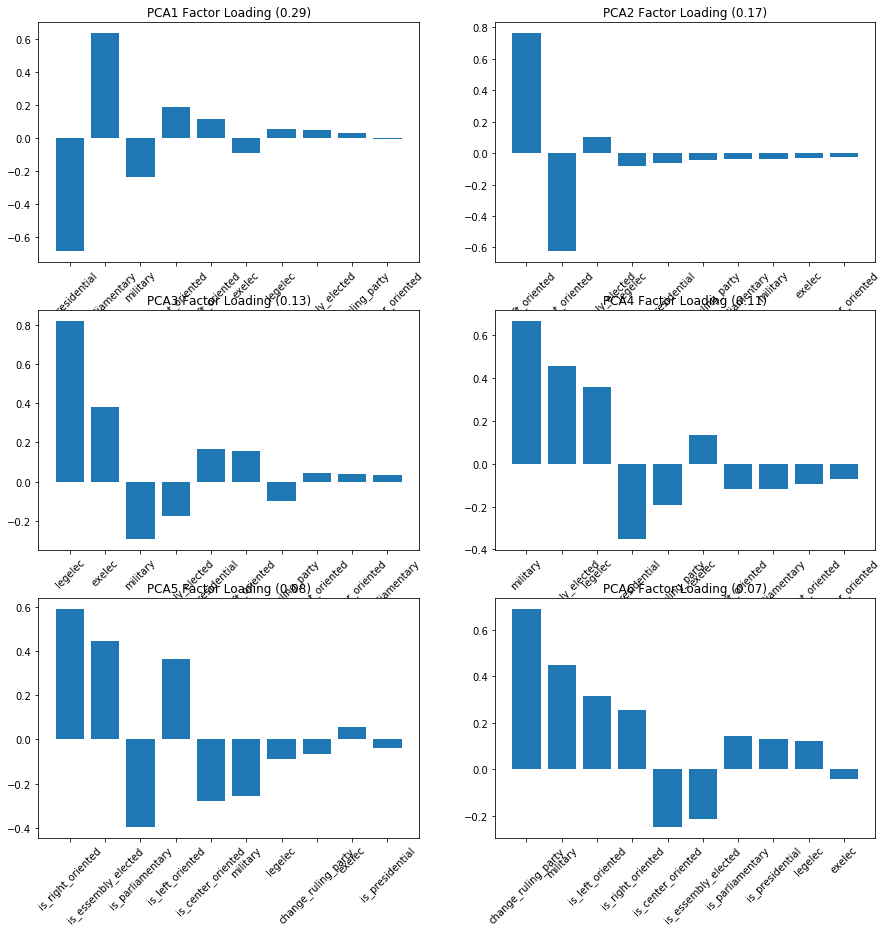

Score on the test dataset 0.7338709677419355


In [238]:
X = gov_terror[['military', 'legelec', 'exelec', 'is_presidential', 'is_parliamentary', 'is_essembly_elected', 
    'is_left_oriented', 'is_right_oriented', 'is_center_oriented', 'change_ruling_party']]
y = gov_terror['attack_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
perform_classifier_with_PCA(X, y, 6, 30)


In [244]:
def get_region_gov_type(_df, comparison):
    for i, r in region_mappings.items():
        fig, ax = plt.subplots(figsize=(10, 10))
        plt.title('{}'.format(r))

        _ax = ax.twinx()

        x = _df[_df.region == i].iyear
        y = _df[_df.region == i].number_of_attacks
        ax.plot(x,y, 'g-')

        x = _df[_df.region == i].iyear
        y = _df[_df.region == i][comparison]
        _ax.plot(x,y, 'b-')

        ax.set_xlabel('Year data')
        ax.set_ylabel('Number of attacks', color='g')
        _ax.set_ylabel(comparison, color='b')

    plt.show()

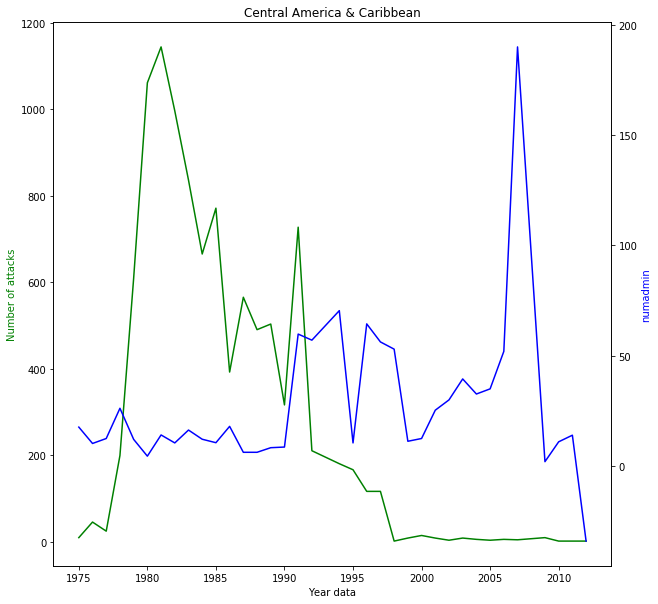

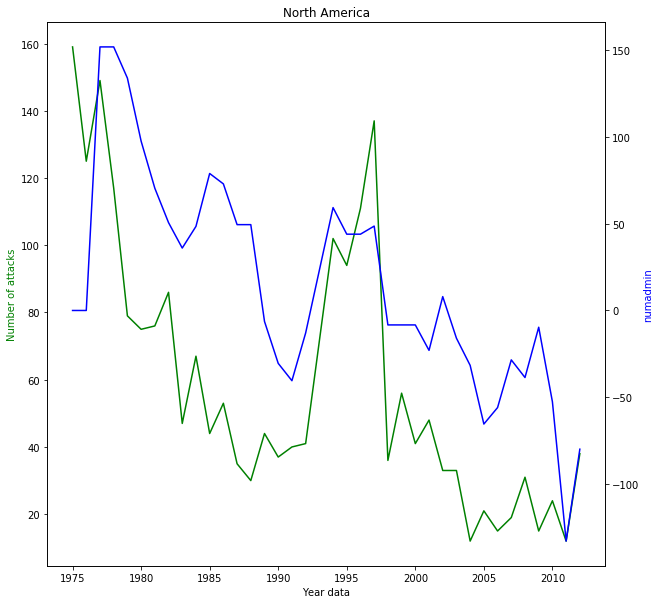

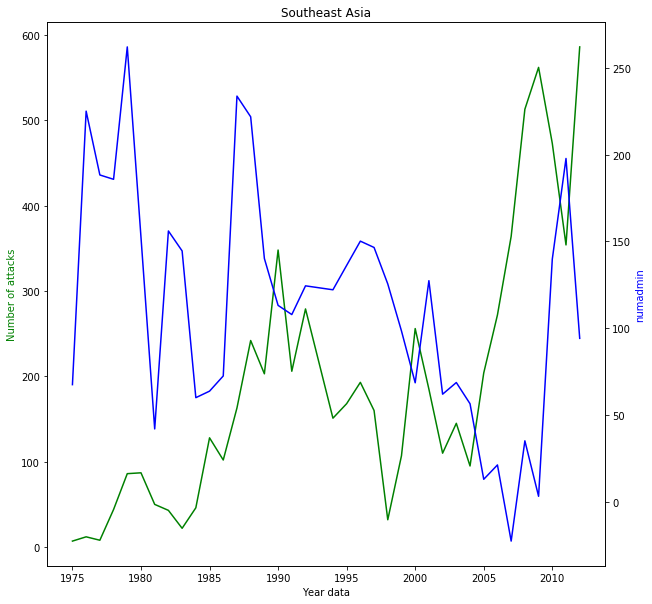

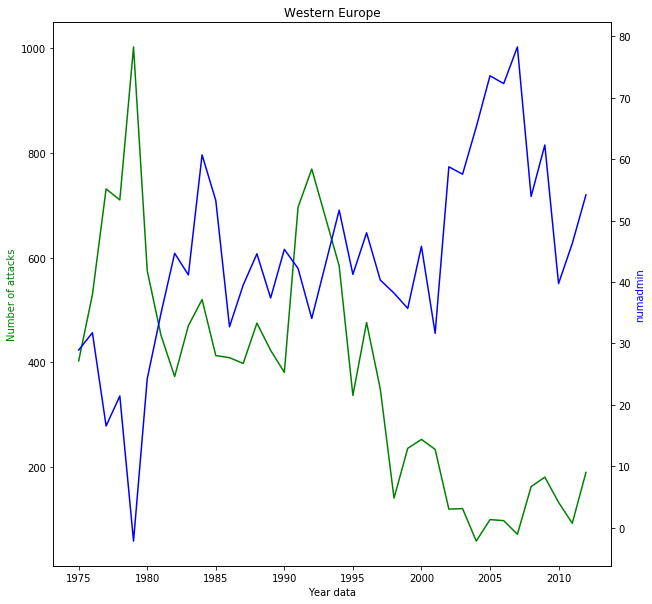

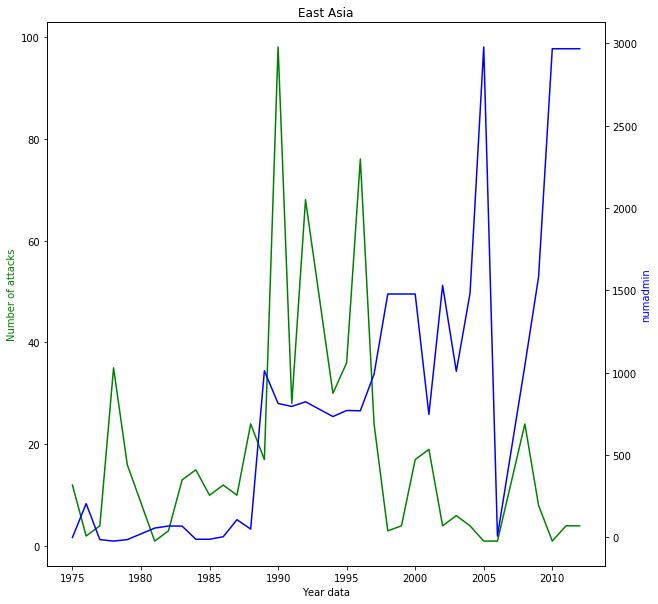

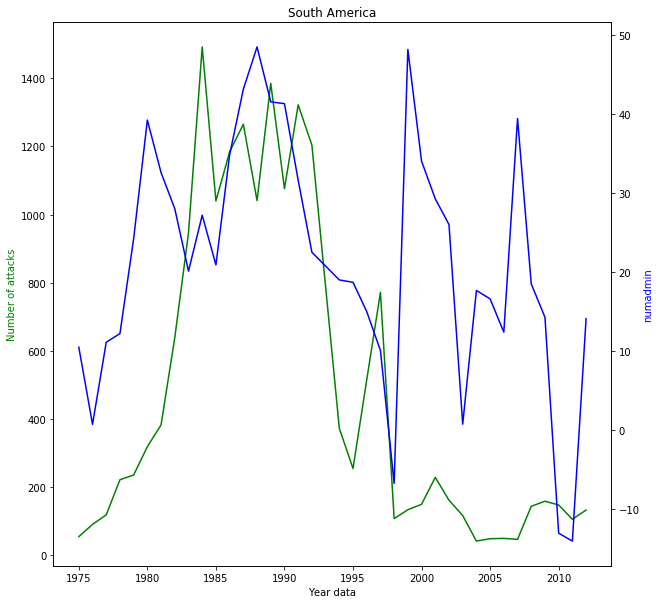

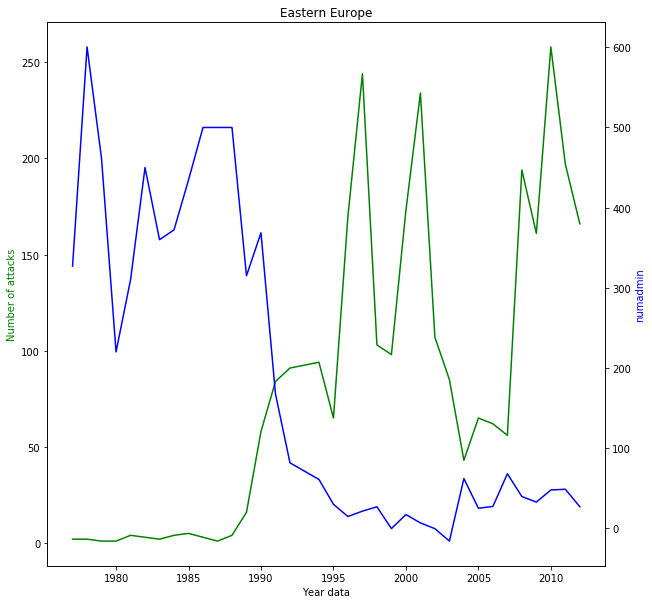

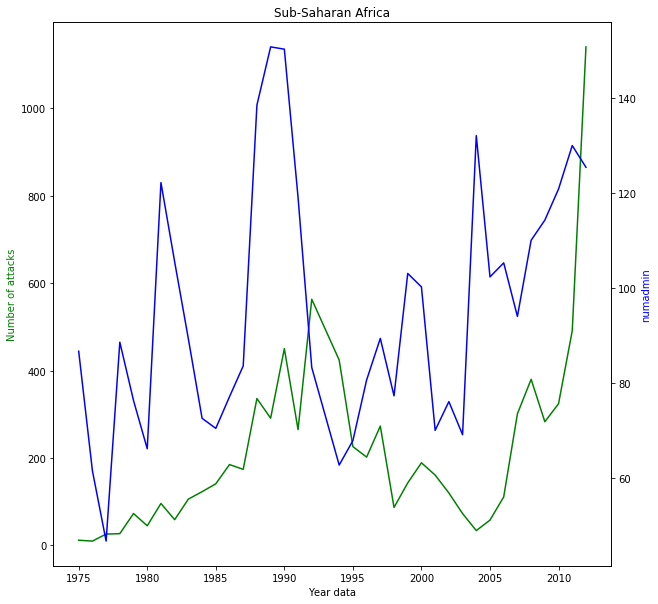

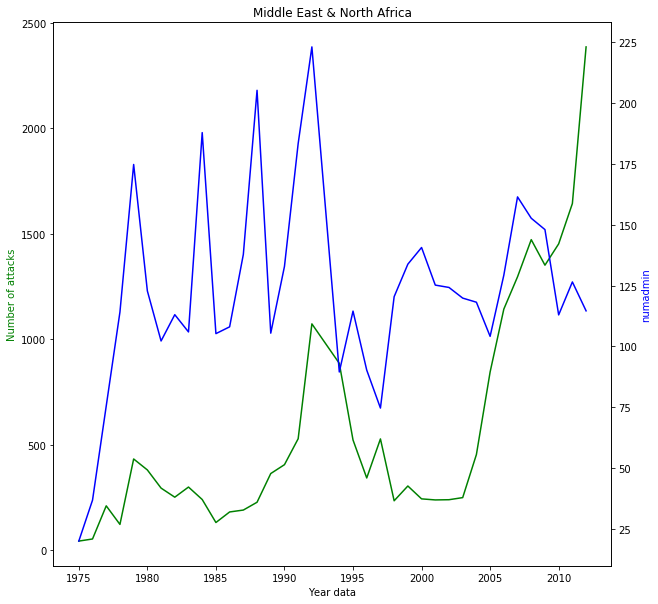

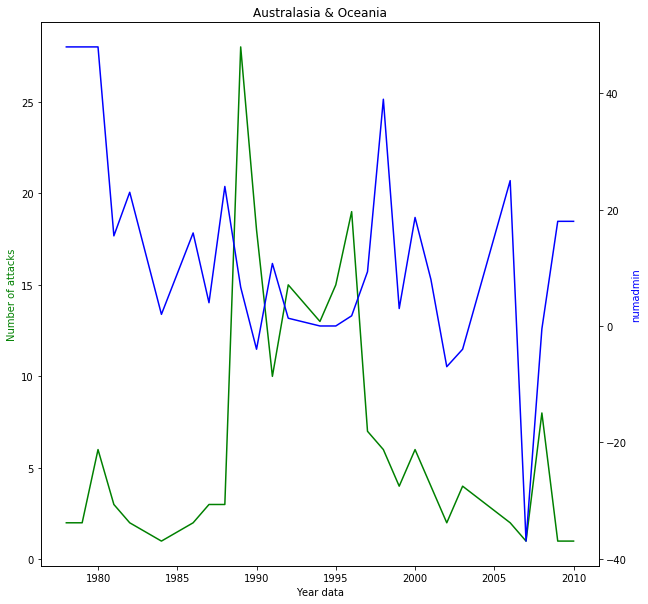

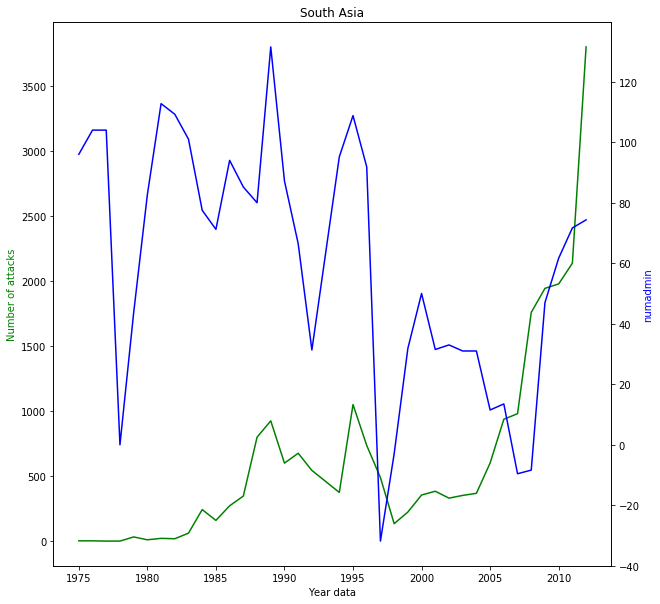

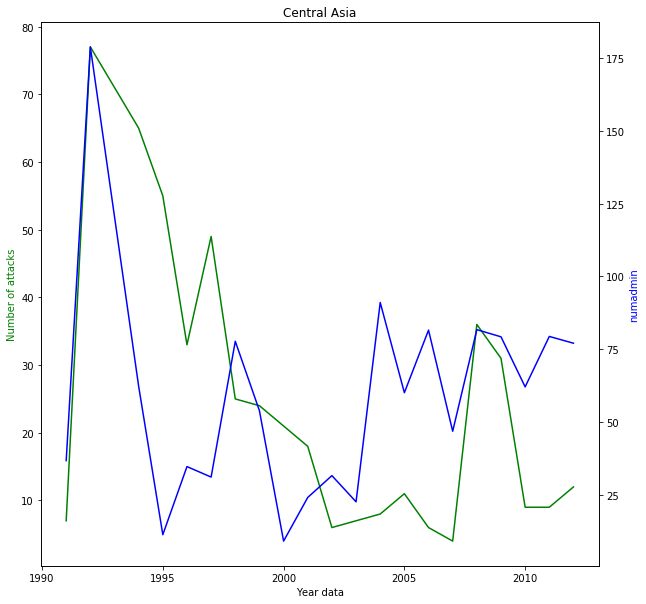

In [247]:
get_region_gov_type(gov_terror_region, 'numadmin')

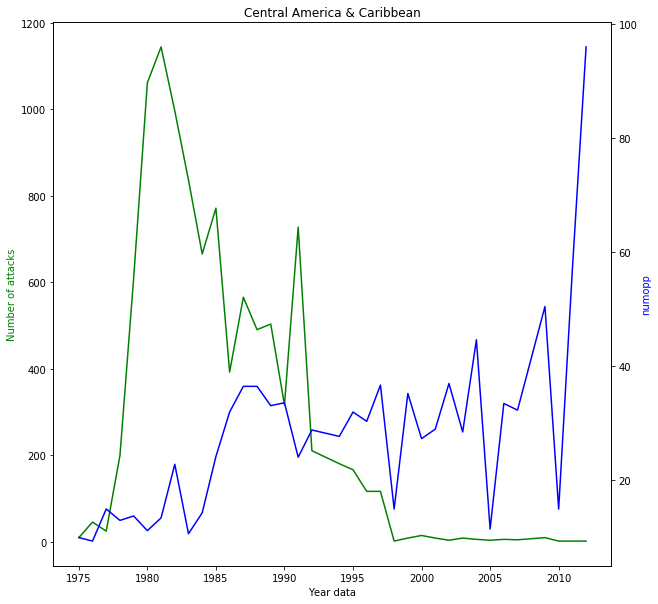

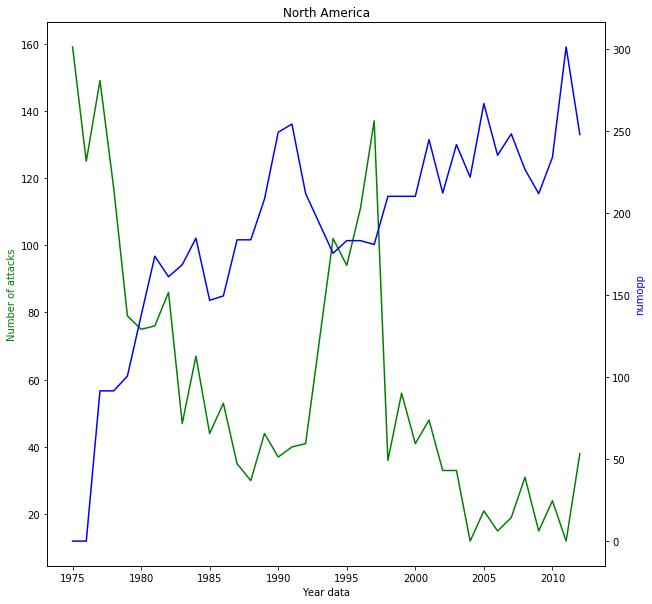

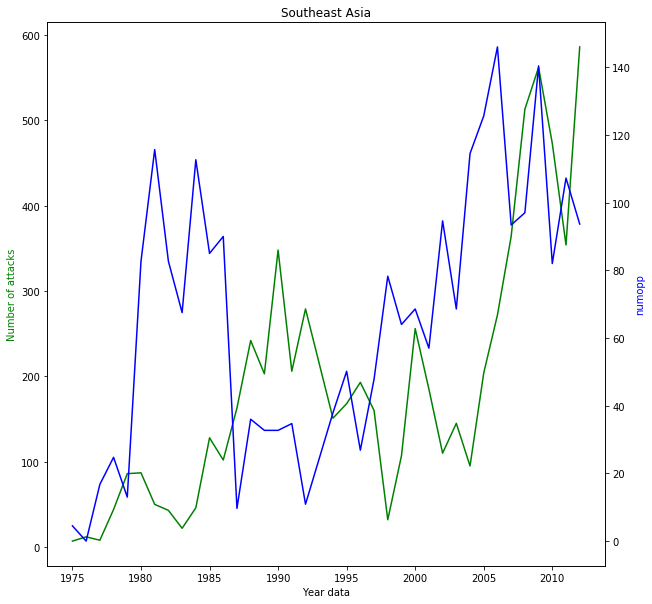

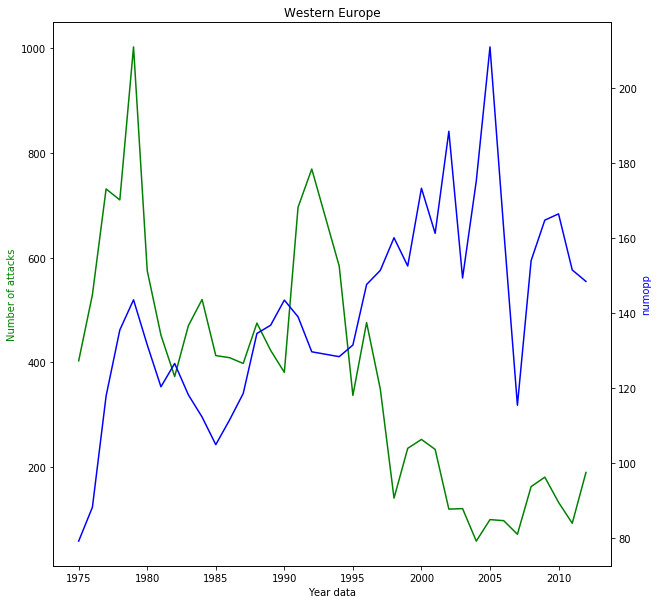

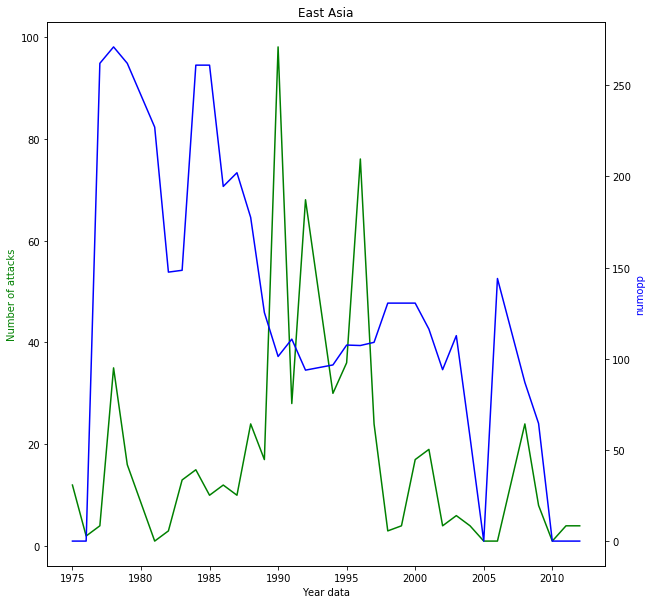

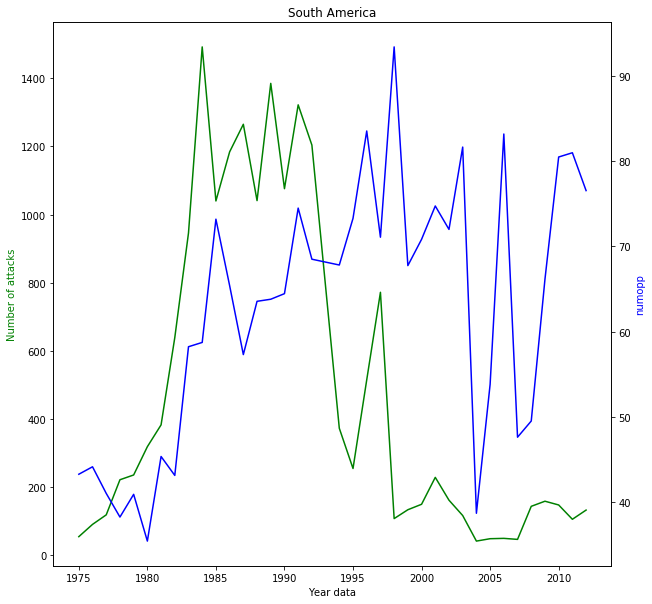

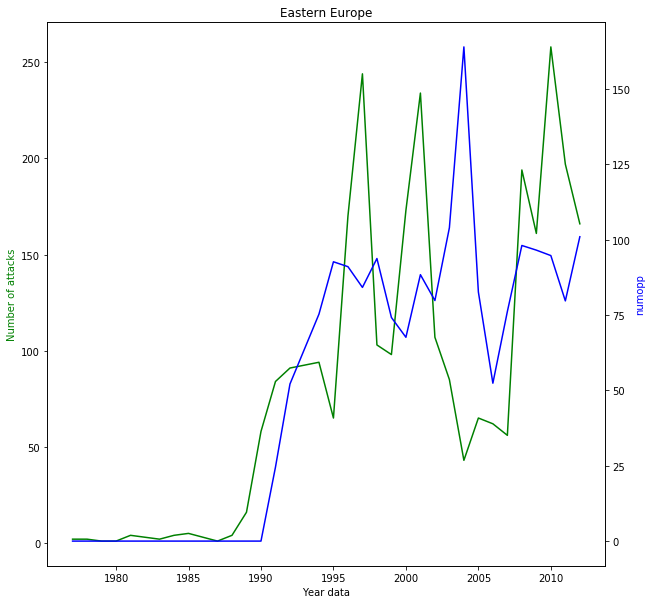

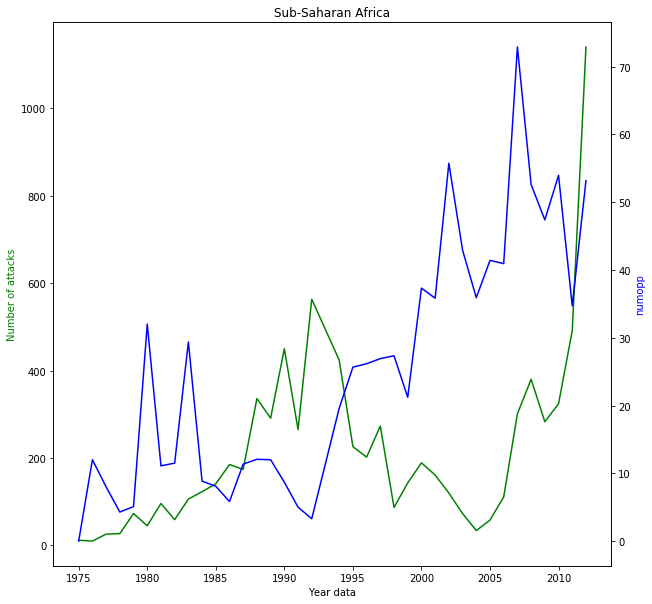

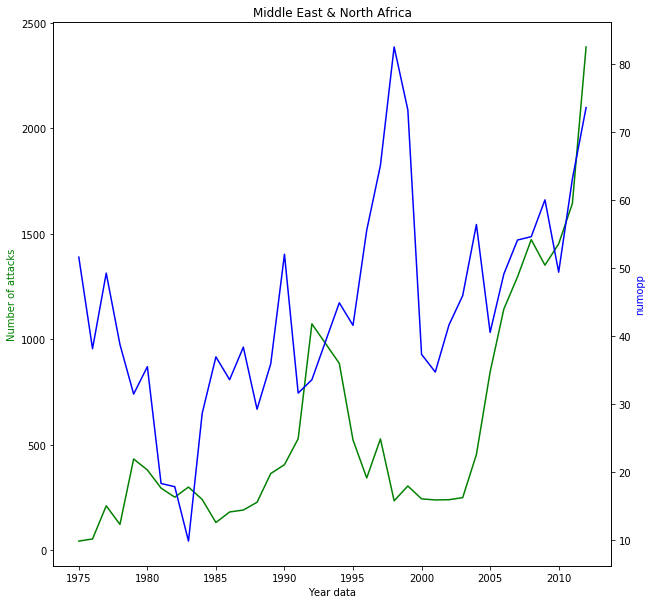

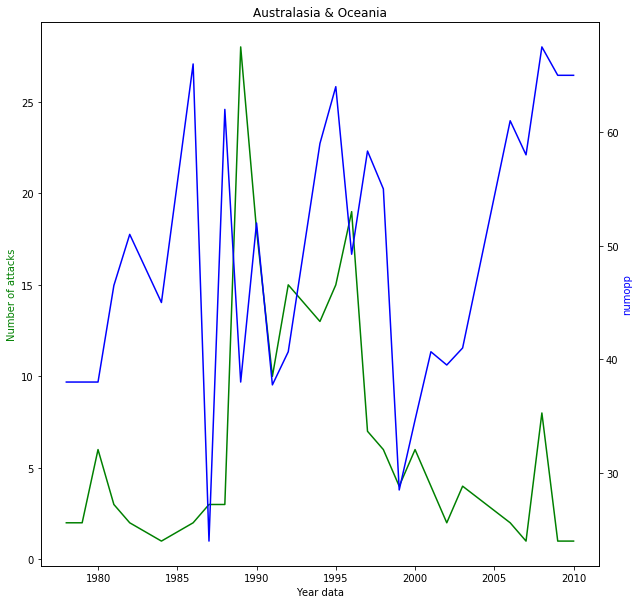

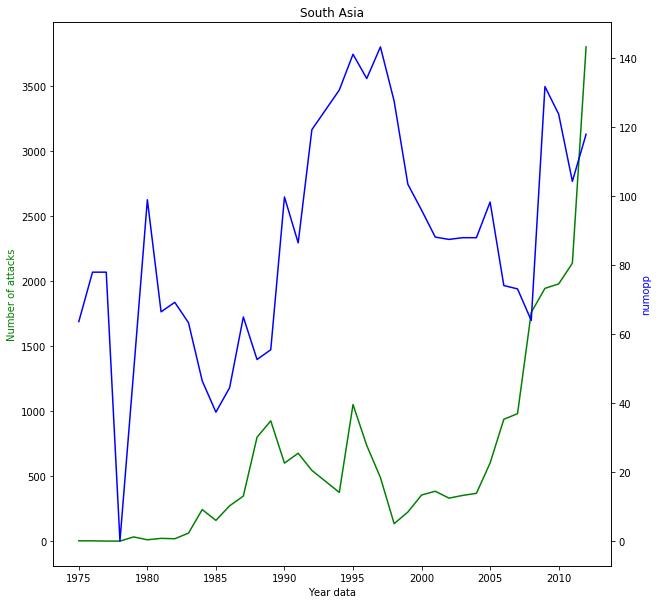

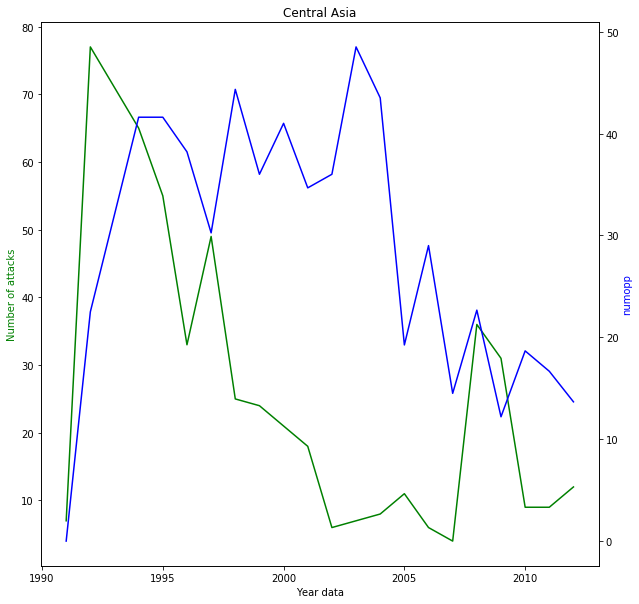

In [248]:
get_region_gov_type(gov_terror_region, 'numopp')

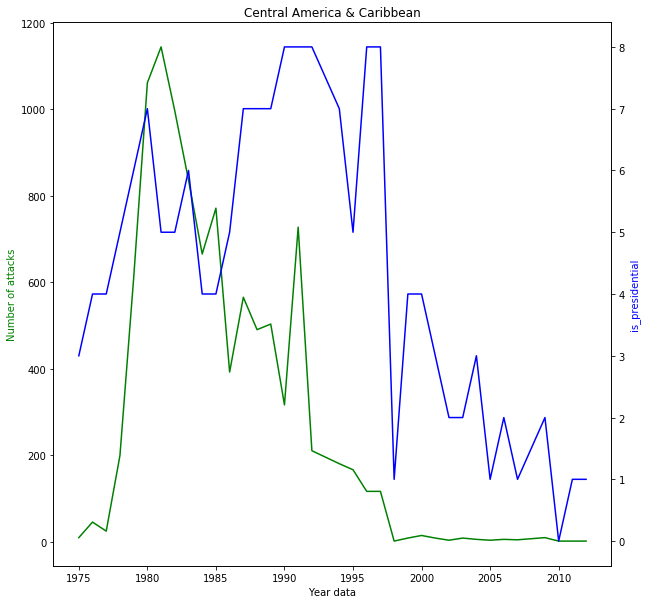

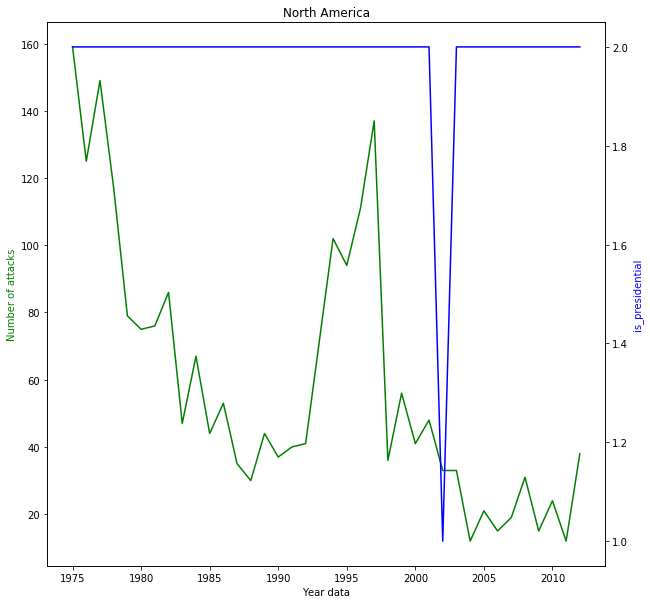

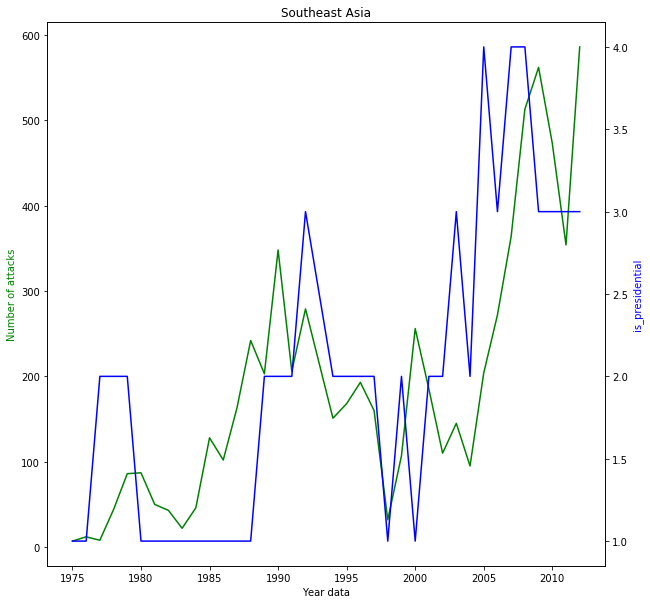

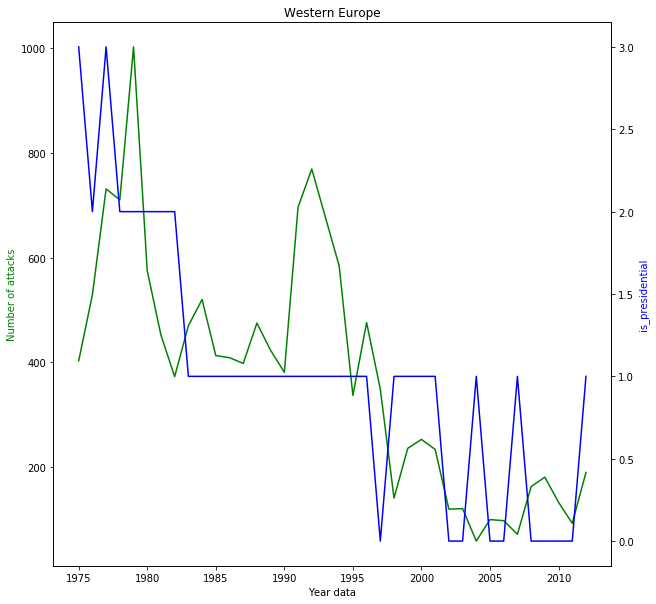

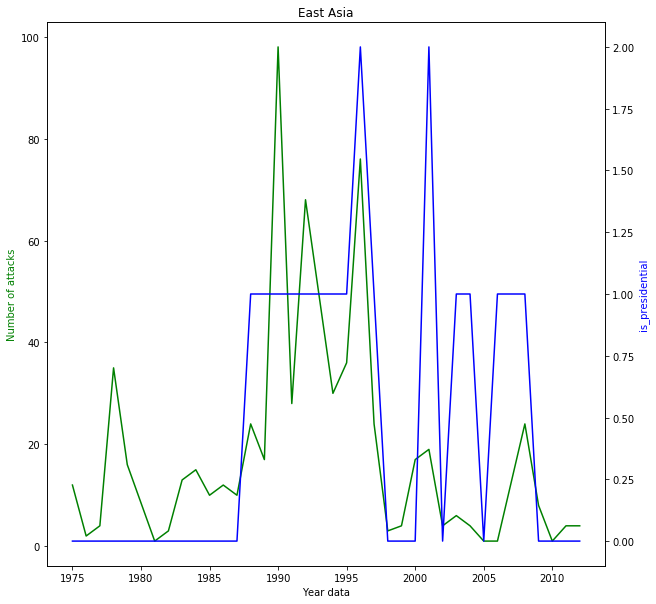

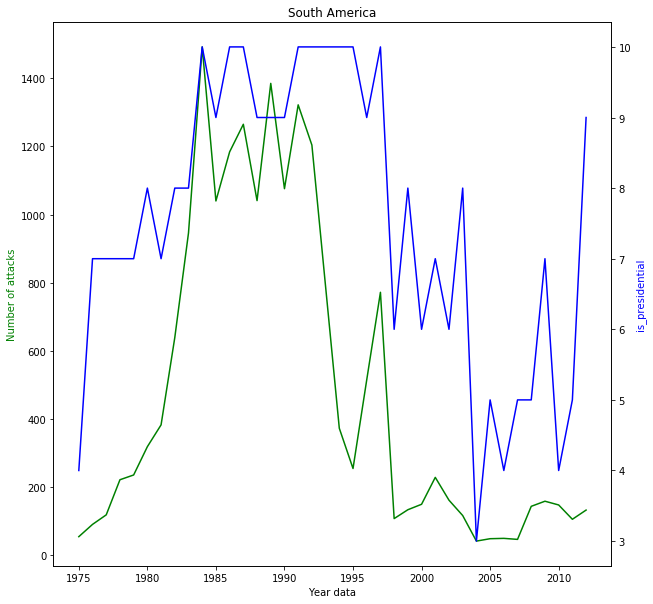

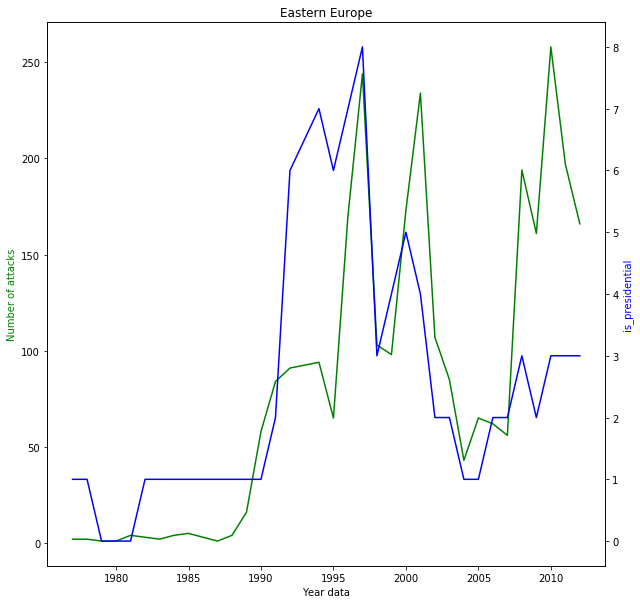

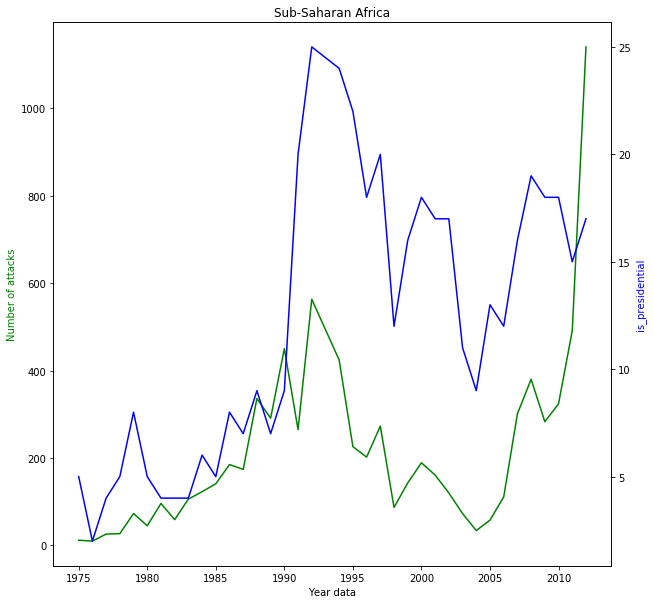

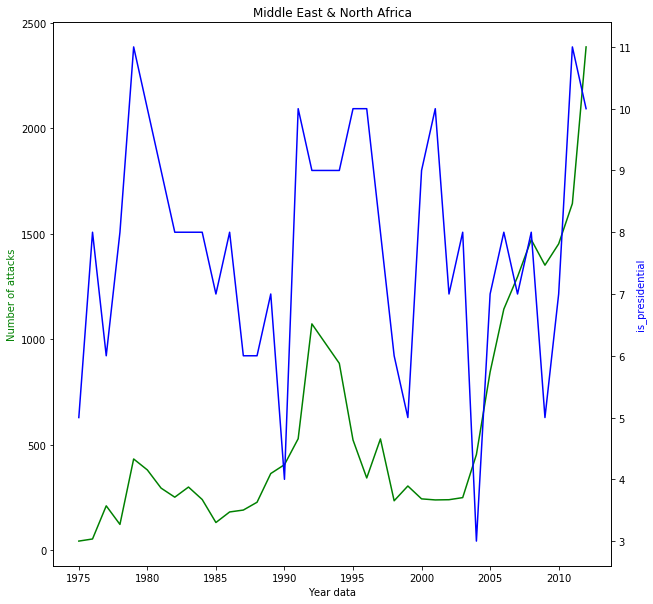

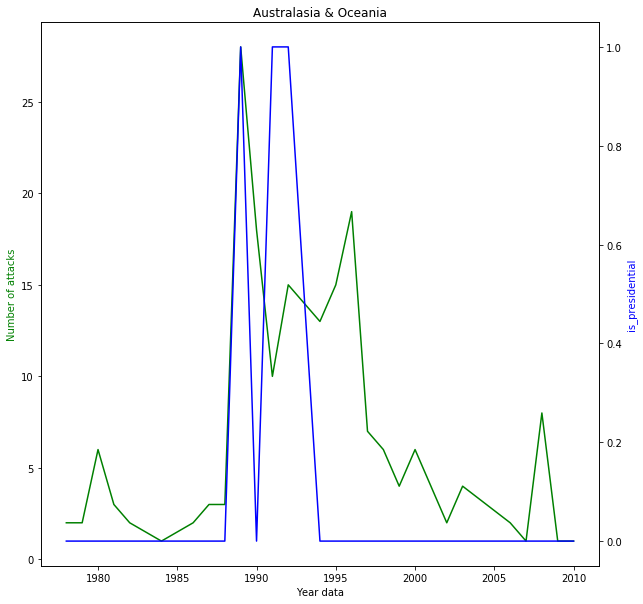

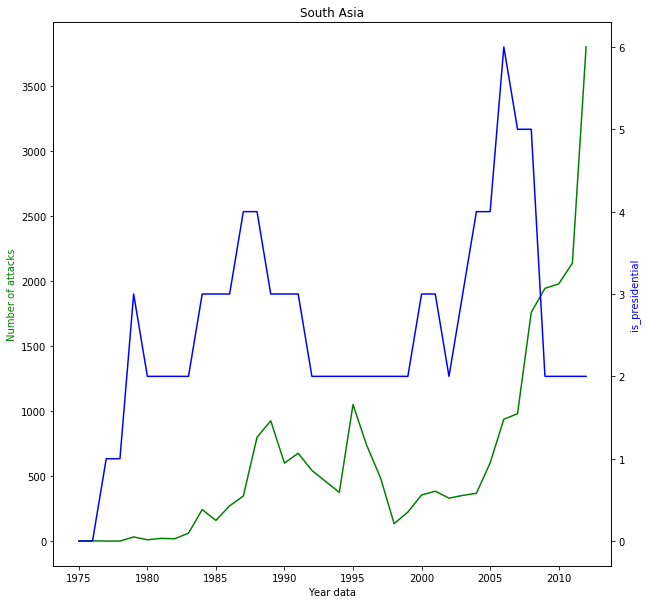

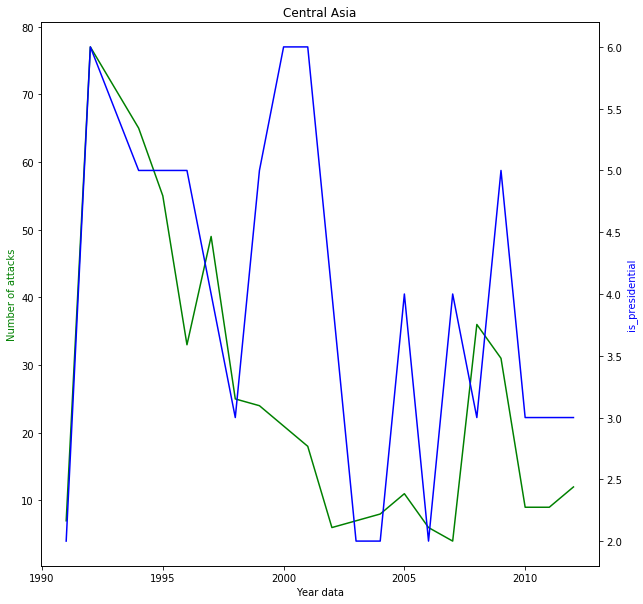

In [249]:
get_region_gov_type(gov_terror_region, 'is_presidential')

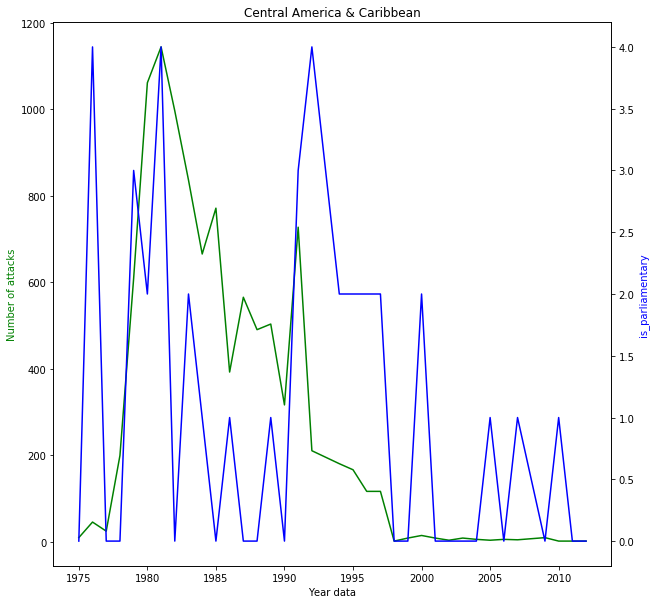

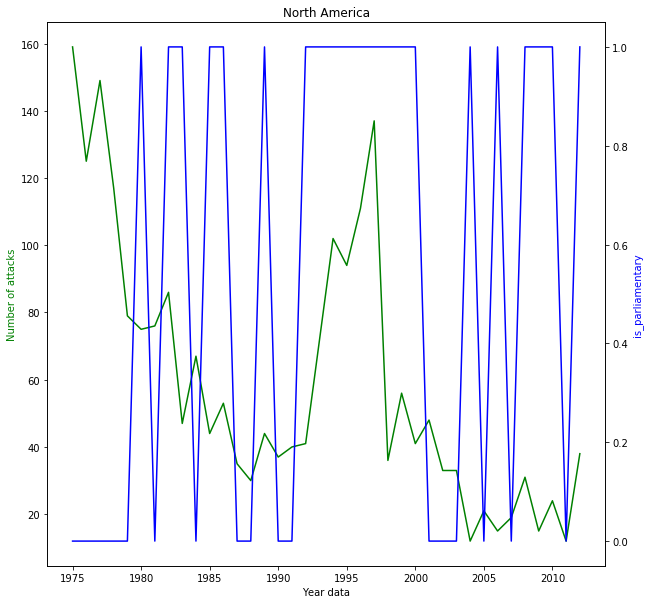

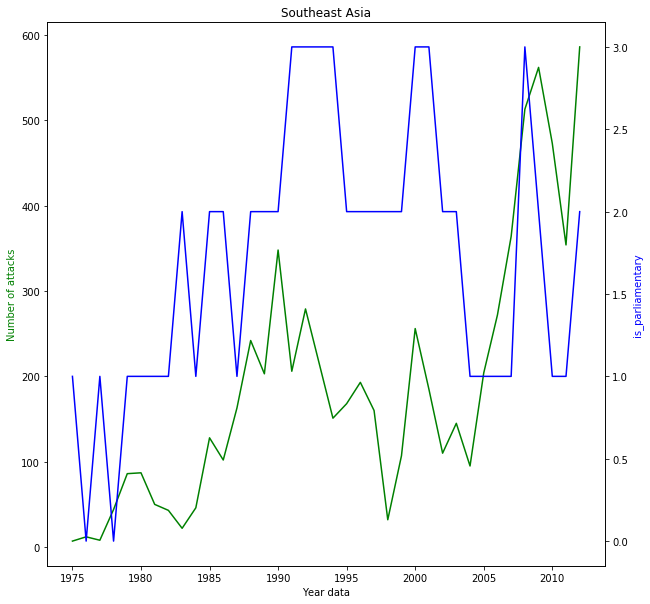

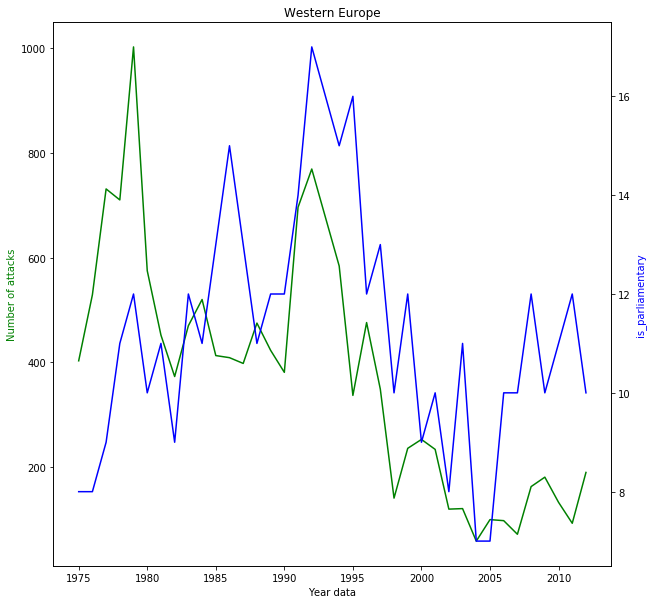

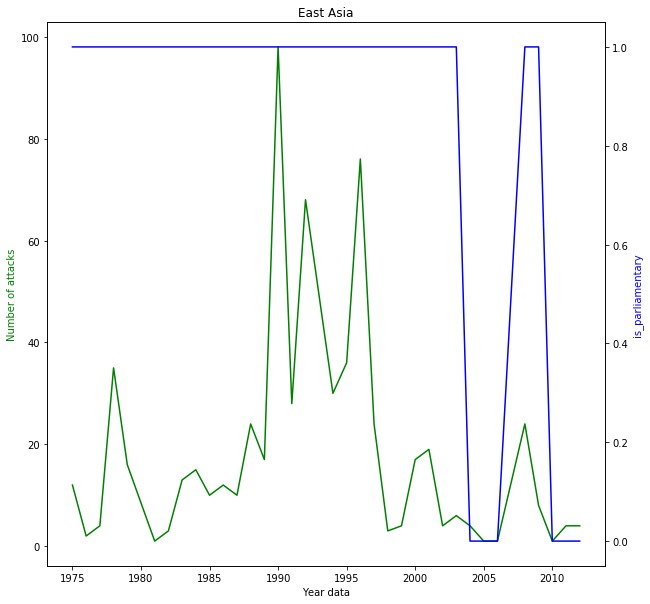

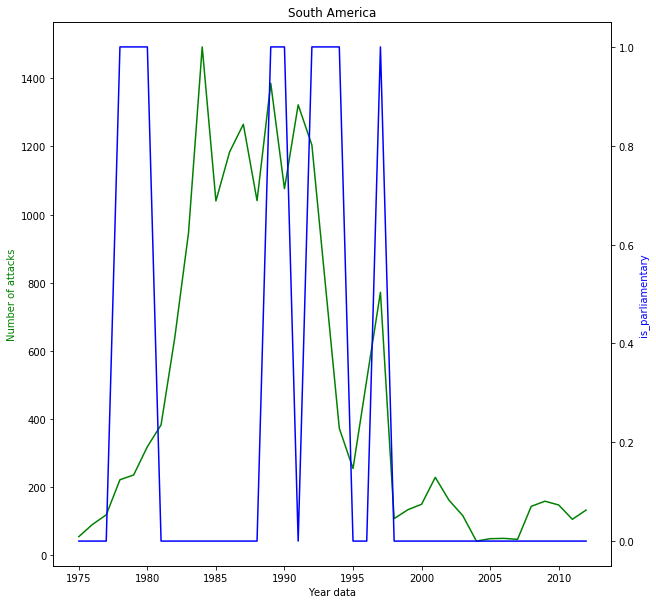

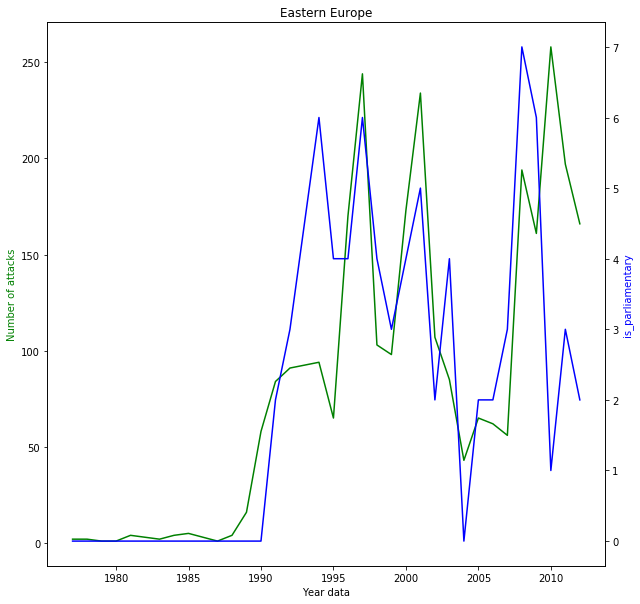

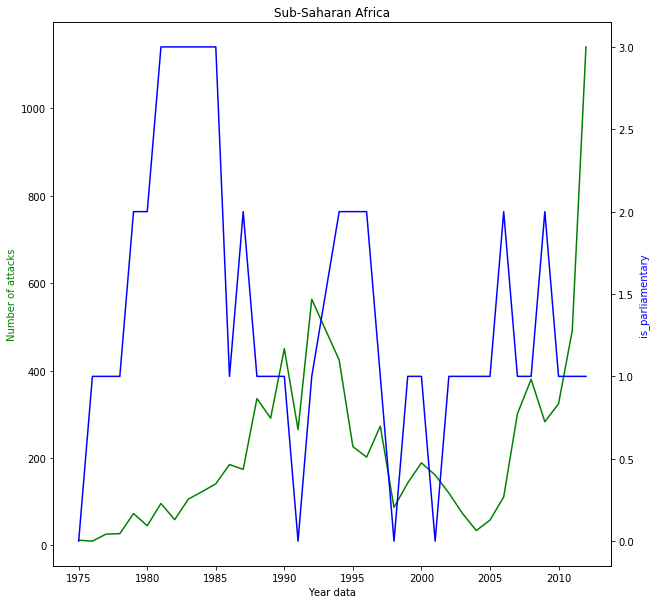

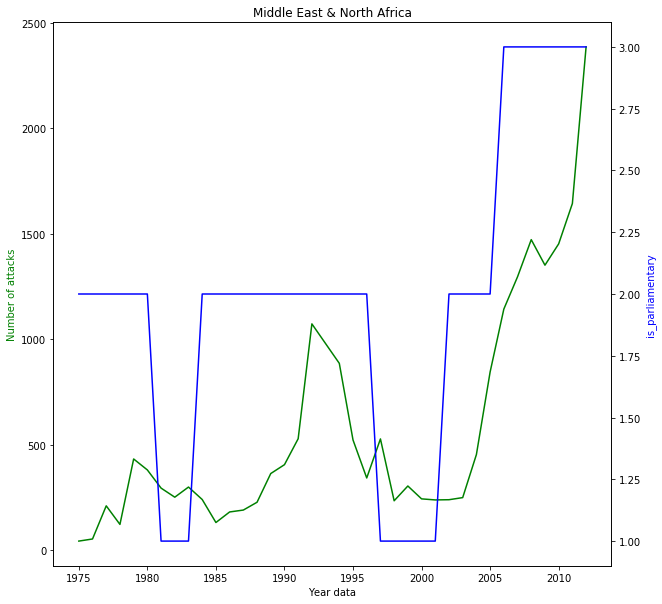

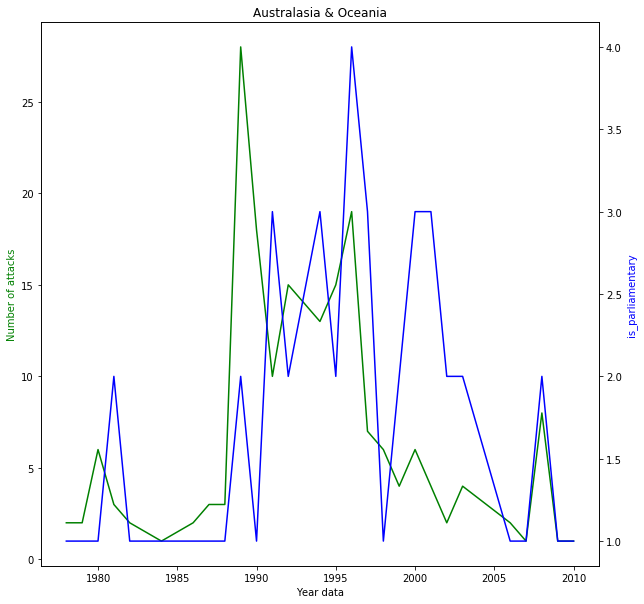

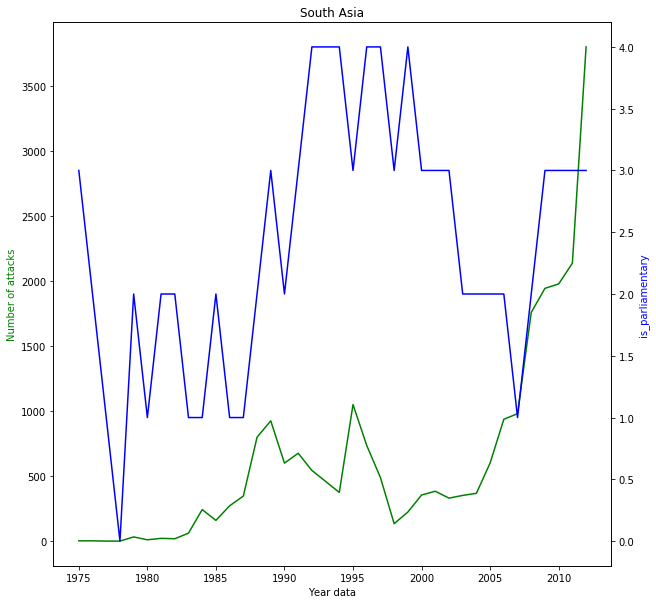

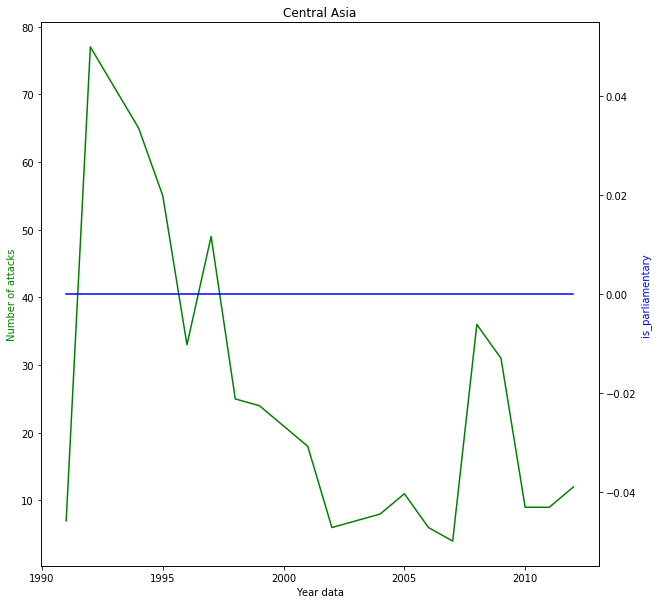

In [250]:
get_region_gov_type(gov_terror_region, 'is_parliamentary')

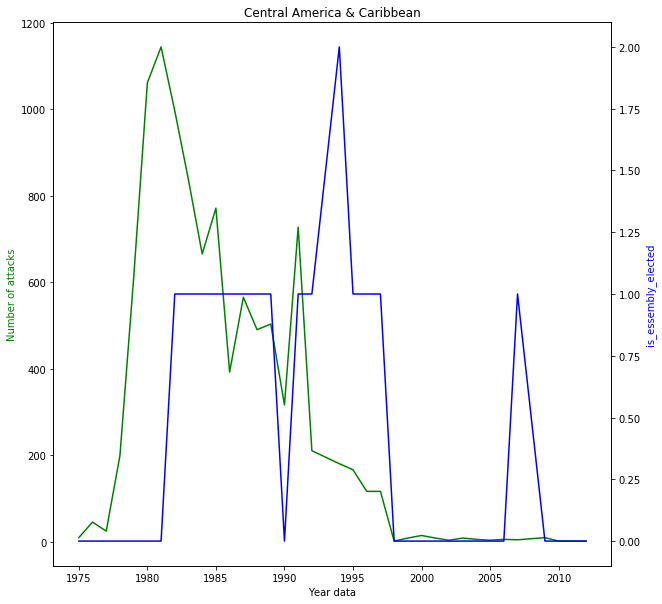

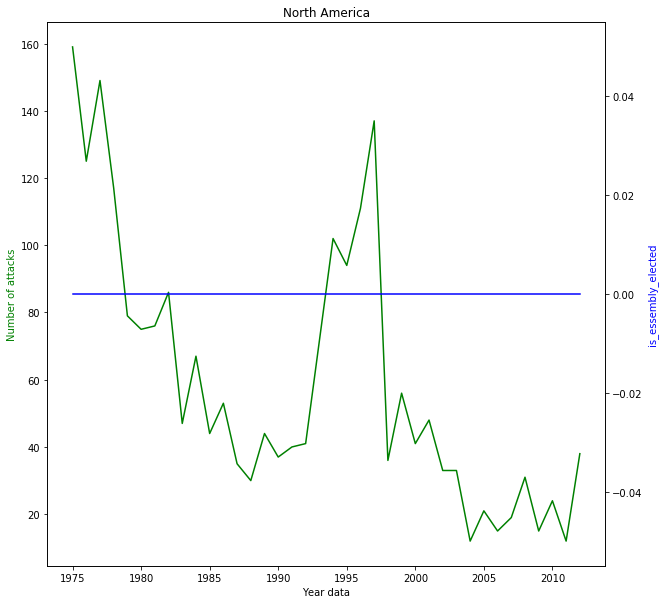

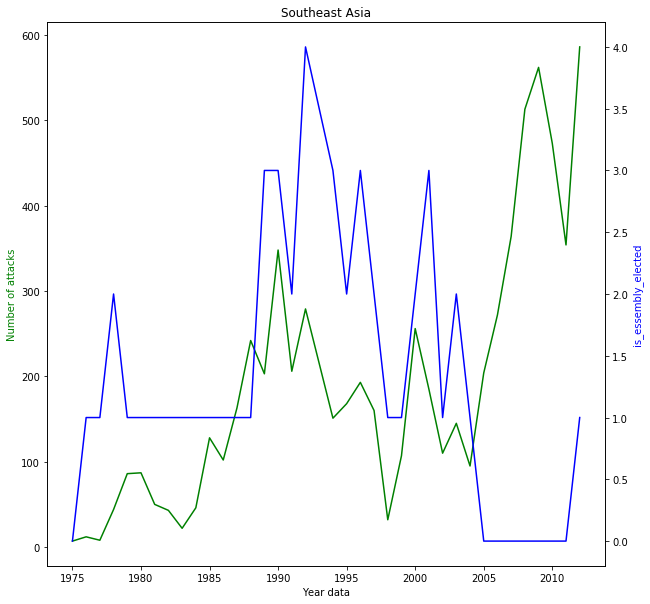

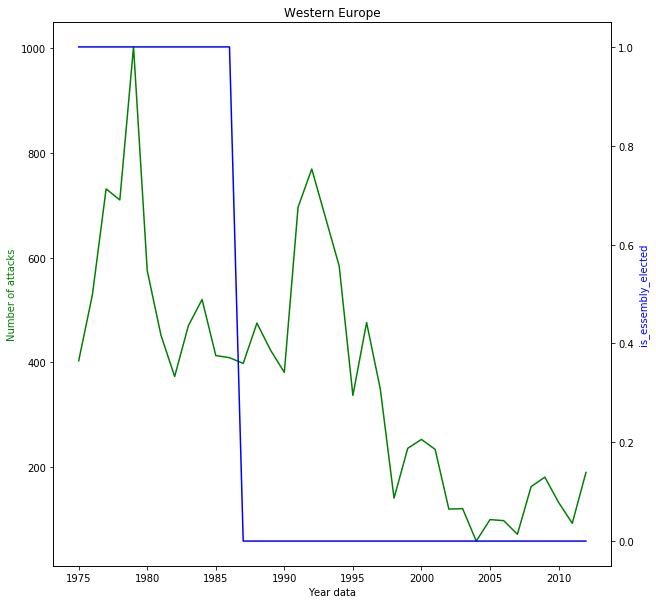

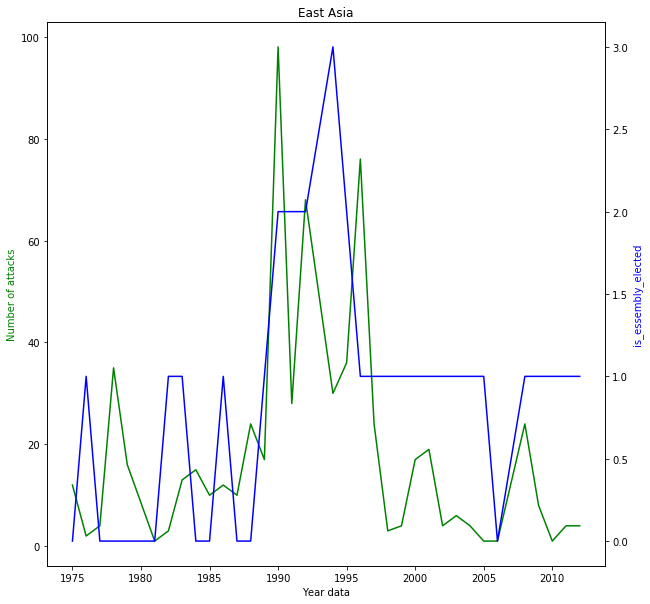

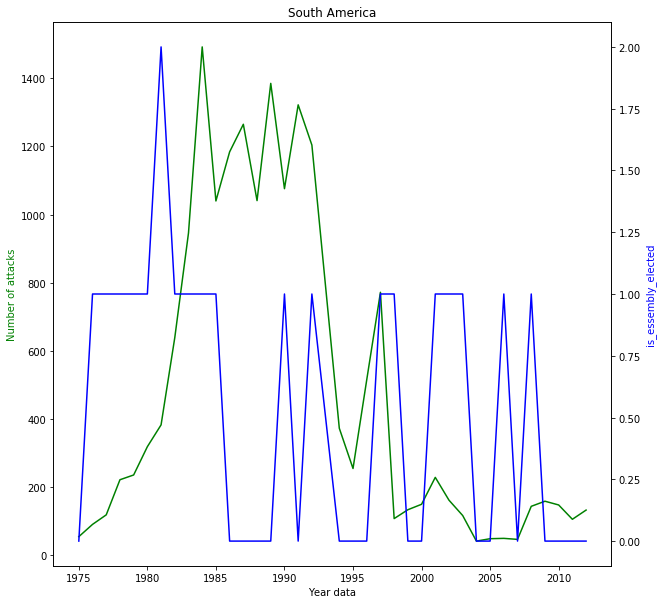

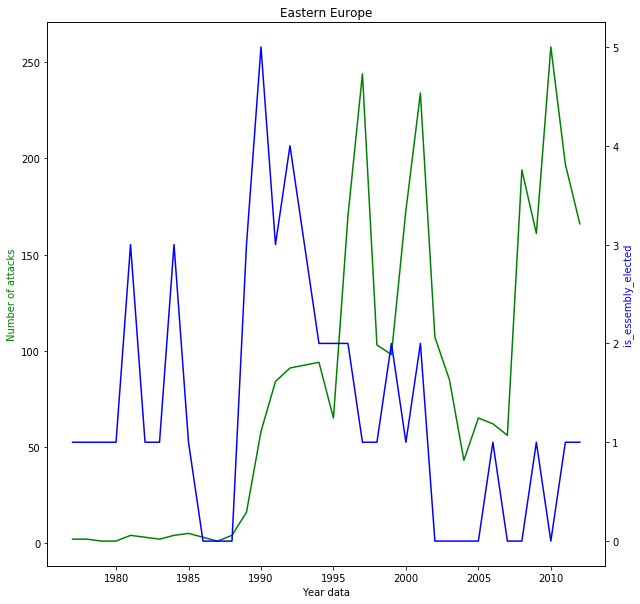

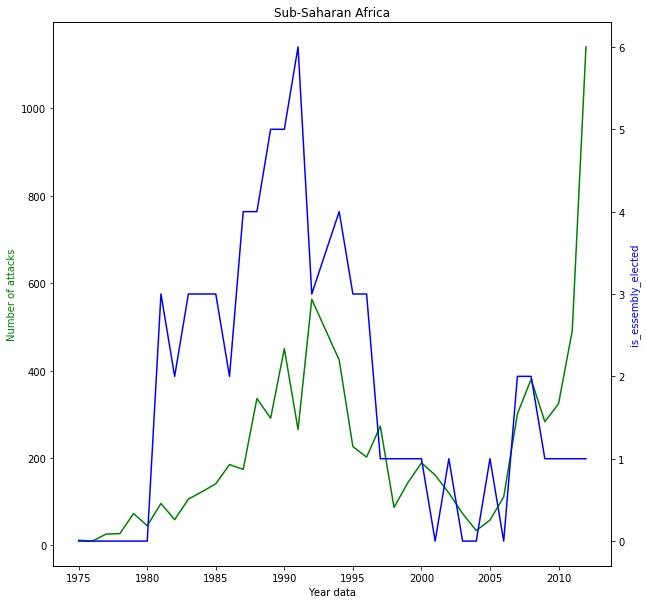

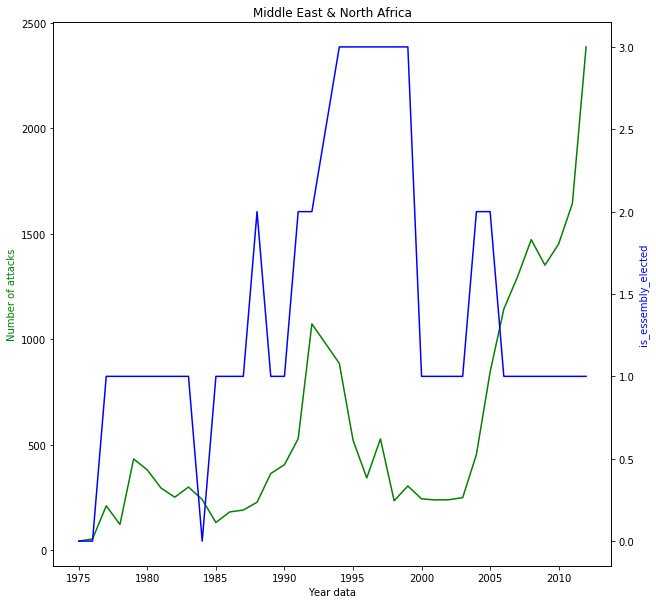

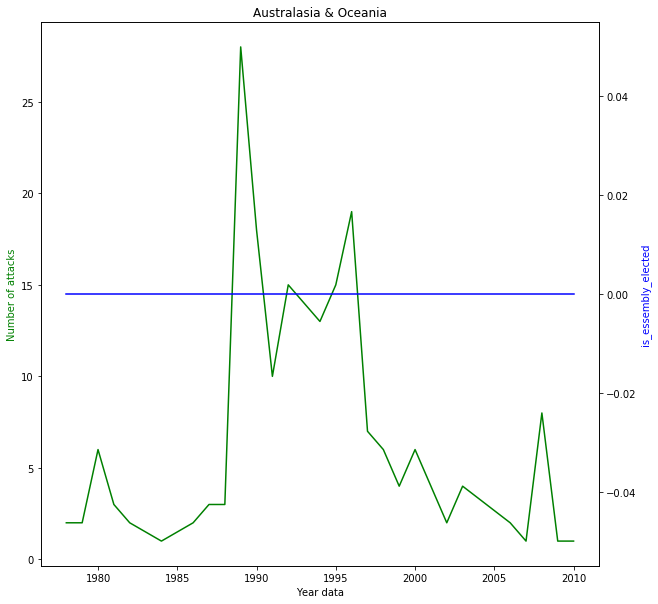

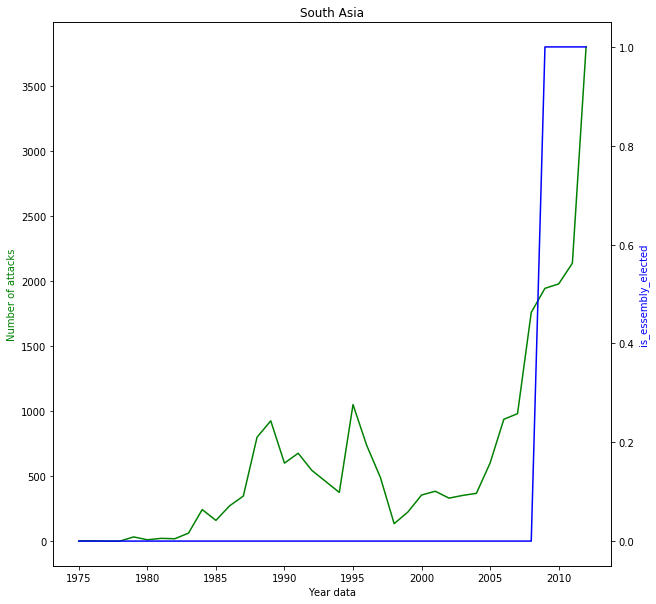

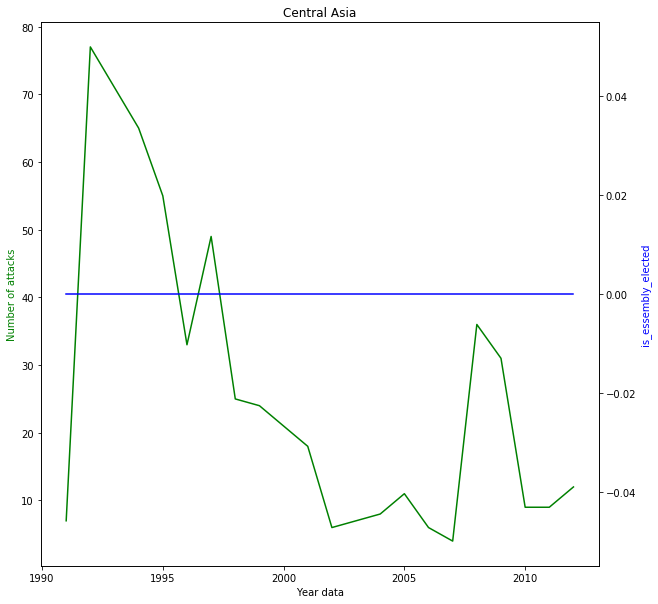

In [251]:
get_region_gov_type(gov_terror_region, 'is_essembly_elected')